In [ ]:
'''
Author: Yiqian Qian
Description: file content
Date: 2025-07-25 23:09:11
LastEditors: Yiqian Qian
LastEditTime: 2025-07-26 13:10:14
FilePath: /DNN_for_GW_Parameter_Space_Estimation/GW_A100_Checkpoints.ipynb
'''
import os
import re
import math
import seaborn as sns
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

import platform

# Ê†πÊçÆÊìç‰ΩúÁ≥ªÁªüËÆæÁΩÆ‰∏≠ÊñáÂ≠ó‰Ωì
system = platform.system()

if system == "Darwin":  # macOS
    plt.rcParams['font.sans-serif'] = ['PingFang SC', 'Heiti SC', 'STHeiti', 'Arial Unicode MS']
elif system == "Linux":
    plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'WenQuanYi Micro Hei', 'Noto Sans CJK SC']
elif system == "Windows":
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'KaiTi', 'FangSong']
else:
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

# Ëß£ÂÜ≥Ë¥üÂè∑ÊòæÁ§∫ÈóÆÈ¢ò
plt.rcParams['axes.unicode_minus'] = False

print(f"Â∑≤ËÆæÁΩÆ{system}Á≥ªÁªüÁöÑ‰∏≠ÊñáÂ≠ó‰ΩìÊîØÊåÅ")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary
from torch.cuda.amp import autocast, GradScaler

Â∑≤ËÆæÁΩÆLinuxÁ≥ªÁªüÁöÑ‰∏≠ÊñáÂ≠ó‰ΩìÊîØÊåÅ


## ÂéªÂô™

In [2]:
# ========== Êï∞ÊçÆË∑ØÂæÑÂíåÂä†ËΩΩÈÖçÁΩÆ ==========
data_folder = "/home/ud202180035/DNN_for_GW_Parameter_Space_Estimation/waveforms2"  # ‰Ω†ÁöÑÊï∞ÊçÆÁõÆÂΩïÔºåÂèØÊåâÈúÄ‰øÆÊîπ
target_snr = ["200.00"]  # ÂèØÊåáÂÆöÂä†ËΩΩÂì™‰∫õ SNR Êï∞ÊçÆ

In [3]:
# ========== ÂàùÂßãÂåñËá™ÂÆö‰πâ Dataset ==========
class GWDataset(Dataset):
    def __init__(self, folder_path, snr_list=None, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.snr_list = snr_list or ["50.00", "100.00", "200.00"]
        
        # Ê£ÄÊü•Êñá‰ª∂Â§πÊòØÂê¶Â≠òÂú®
        if not os.path.isdir(folder_path):
            raise FileNotFoundError(f"Êï∞ÊçÆÁõÆÂΩï‰∏çÂ≠òÂú®: {folder_path}")
            
        self.file_index = []
        snr_pattern = re.compile(r"_SNR(\d+\.\d+)\.h5")

        # ‰ΩøÁî®Êõ¥ÂÆâÂÖ®ÁöÑÊñπÂºèÈÅçÂéÜÊñá‰ª∂
        for fname in os.listdir(folder_path):
            if not fname.endswith(".h5"):
                continue
                
            full_path = os.path.join(folder_path, fname)
            
            # Ë∑≥ËøáÈùûÊñá‰ª∂È°πÔºàÂ¶ÇÁõÆÂΩïÔºâ
            if not os.path.isfile(full_path):
                print(f"Ë∑≥ËøáÈùûÊñá‰ª∂È°π: {full_path}")
                continue
                
            # Ê£ÄÊü•Êñá‰ª∂ÂèØËØªÊÄß
            if not os.access(full_path, os.R_OK):
                print(f"Ë≠¶Âëä: Êñá‰ª∂‰∏çÂèØËØªÔºåË∑≥Ëøá: {full_path}")
                continue
                
            match = snr_pattern.search(fname)
            if match:
                snr = match.group(1)
                if snr in self.snr_list:
                    # Â∞ùËØïÊâìÂºÄÊñá‰ª∂‰ª•È™åËØÅÂÆåÊï¥ÊÄß
                    try:
                        with h5py.File(full_path, "r") as f:
                            # ÁÆÄÂçïÈ™åËØÅÊñá‰ª∂ÁªìÊûÑ
                            if "Data" not in f:
                                print(f"Ë≠¶Âëä: Êñá‰ª∂Áº∫Â∞ë'Data'ÁªÑÔºåË∑≥Ëøá: {full_path}")
                                continue
                                
                            # Ê£ÄÊü•ÂøÖË¶ÅÂ±ûÊÄß
                            data_group = f["Data"]
                            required_attrs = ["mc_true", "phis_true", "thetas_true"]
                            if not all(attr in data_group.attrs for attr in required_attrs):
                                print(f"Ë≠¶Âëä: Êñá‰ª∂Áº∫Â∞ëÂøÖË¶ÅÂ±ûÊÄßÔºåË∑≥Ëøá: {full_path}")
                                continue
                                
                        # Êñá‰ª∂È™åËØÅÈÄöËøáÔºåÊ∑ªÂä†Âà∞Á¥¢Âºï
                        self.file_index.append((full_path, snr))
                        
                    except (OSError, IOError) as e:
                        print(f"Êñá‰ª∂ÊâìÂºÄÈîôËØØ {full_path}: {str(e)}ÔºåË∑≥Ëøá")
                    except Exception as e:
                        print(f"Â§ÑÁêÜÊñá‰ª∂Êó∂Âá∫Èîô {full_path}: {str(e)}ÔºåË∑≥Ëøá")

        if not self.file_index:
            raise ValueError("Ê≤°ÊúâÂåπÈÖçÂà∞‰ªª‰ΩïÊåáÂÆö SNR ÁöÑÊñá‰ª∂ÔºåËØ∑Ê£ÄÊü•Ë∑ØÂæÑÊàñ snr_list ËÆæÁΩÆ")
        else:
            print(f"ÊàêÂäüÂä†ËΩΩ {len(self.file_index)} ‰∏™Êñá‰ª∂")

    def __len__(self):
        return len(self.file_index)

    def __getitem__(self, idx):
        file_path, snr = self.file_index[idx]
        
        try:
            with h5py.File(file_path, "r") as f:
                data_group = f["Data"]
                
                # Â§ÑÁêÜ‰∏çÂêåÁöÑÊï∞ÊçÆÁªìÊûÑ
                if isinstance(data_group, h5py.Group):
                    white_data = torch.tensor(data_group["white_Data"][:], dtype=torch.float32)
                    white_signal = torch.tensor(data_group["white_signal"][:], dtype=torch.float32)
                elif isinstance(data_group, h5py.Dataset):
                    # Â§ÑÁêÜÊóßÊ†ºÂºèÁöÑÊï∞ÊçÆÈõÜ
                    white_data = torch.tensor(data_group[0].flatten(), dtype=torch.float32)
                    white_signal = torch.tensor(data_group[1].flatten(), dtype=torch.float32)
                else:
                    raise ValueError(f"Êú™Áü•ÁöÑÊï∞ÊçÆÁªìÊûÑ: {file_path}")
                
                attrs = {k: data_group.attrs[k] for k in data_group.attrs}
                
        except (OSError, IOError) as e:
            # Êñá‰ª∂ËØªÂèñÈîôËØØÊó∂ËøîÂõûÁ©∫Êï∞ÊçÆÂπ∂ËÆ∞ÂΩïË≠¶Âëä
            print(f"ËØªÂèñÊñá‰ª∂ÈîôËØØ {file_path}: {str(e)}")
            seq_len = 6184  # ÈªòËÆ§Â∫èÂàóÈïøÂ∫¶
            white_data = torch.zeros(seq_len, dtype=torch.float32)
            white_signal = torch.zeros(seq_len, dtype=torch.float32)
            attrs = {
                "mc_true": 0.0,
                "phis_true": 0.0,
                "thetas_true": 0.0
            }
        except Exception as e:
            print(f"Â§ÑÁêÜÊñá‰ª∂Êó∂ÂèëÁîüÊÑèÂ§ñÈîôËØØ {file_path}: {str(e)}")
            raise e

        sample = {
            "white_data": white_data,
            "white_signal": white_signal,
            "attributes": attrs,
            "mc_true": attrs.get("mc_true", 0.0),
            "phis_true": attrs.get("phis_true", 0.0),
            "thetas_true": attrs.get("thetas_true", 0.0),
            "snr": snr,
            "filename": os.path.basename(file_path)
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

In [3]:
# ========== ÂàõÂª∫Êï∞ÊçÆÈõÜÂØπË±° ==========
try:
    dataset = GWDataset(data_folder, snr_list=target_snr)
    print(f"ÂÖ±Âä†ËΩΩÊ†∑Êú¨Êï∞Èáè: {len(dataset)}")
except Exception as e:
    print(f"Êï∞ÊçÆÈõÜÂàùÂßãÂåñÂ§±Ë¥•: {str(e)}")
    # ÂàõÂª∫Á©∫Êï∞ÊçÆÈõÜÈò≤Ê≠¢ÂêéÁª≠‰ª£Á†ÅÂ¥©Ê∫É
    class EmptyDataset(Dataset):
        def __len__(self): return 0
        def __getitem__(self, idx): return {}
    dataset = EmptyDataset()

KeyboardInterrupt: 

In [3]:
sample = dataset[0]
print("white_data shape:", sample["white_data"].shape)
print("white_signal shape:", sample["white_signal"].shape)

white_data shape: torch.Size([61852])
white_signal shape: torch.Size([61852])


In [4]:
# ÊûÑÂª∫Êé©Á†Å 1Ë°®Á§∫Âº±‰ø°Âè∑Ôºå0Ë°®Á§∫Âº∫‰ø°Âè∑Ôºå2Ë°®Á§∫Á¨¨‰∫åÊÆµÂº±‰ø°Âè∑
def generate_mask(data: torch.Tensor, threshold_factor=5.0):
    B, L = data.shape
    mask = torch.ones_like(data, dtype=torch.long)  # ÂàùÂßã‰∏∫ÂÖ®1ÔºàÂº±‰ø°Âè∑Ôºâ
    stds = torch.std(data, dim=1, keepdim=True)  # (B, 1)
    thresholds = threshold_factor * stds         # ÊØèÊù°Êï∞ÊçÆÁöÑÈòàÂÄº (B, 1)

    abs_data = data.abs()  # (B, L)
    for i in range(B):
        above_th = (abs_data[i] > thresholds[i])  # bool mask
        strong_indices = torch.nonzero(above_th).squeeze()

        if strong_indices.numel() > 0:
            # Â§ÑÁêÜ0Áª¥Âº†ÈáèÁöÑÊÉÖÂÜµÔºàÂè™Êúâ‰∏Ä‰∏™Âº∫‰ø°Âè∑ÁÇπÔºâ
            if strong_indices.dim() == 0:
                start = end = strong_indices.item()
            else:
                start = strong_indices[0].item()
                end = strong_indices[-1].item()
            
            mask[i, start:end+1] = 0  # Âº∫‰ø°Âè∑ÔºàÂåÖÂê´endÁÇπÔºâ
            mask[i, end+1:] = 2       # Á¨¨‰∫åÊÆµÂº±‰ø°Âè∑

    return mask

In [5]:
# Ê†áÂáÜÂåñ
def standardize_batch(data: torch.Tensor, signal: torch.Tensor, mask: torch.Tensor, amplification=1.0):
    # ÊîæÂ§ßÂº±‰ø°Âè∑ÈÉ®ÂàÜ
    signal_amplified = signal.clone()
    signal_amplified[mask == 1] *= amplification

    # ÊèêÂèñÂº±‰ø°Âè∑Á¥¢Âºï
    weak_indices = (mask == 1)

    # RobustScaler Ê®°ÊãüÔºö‰∏≠‰ΩçÊï∞‰∏é IQRÔºàËøë‰ººÊ†áÂáÜÂåñÔºâ
    weak_values = data[weak_indices].view(-1)
    median = weak_values.median()
    q1 = weak_values.kthvalue(int(len(weak_values) * 0.25))[0]
    q3 = weak_values.kthvalue(int(len(weak_values) * 0.75))[0]
    iqr = q3 - q1 + 1e-8  # ÈÅøÂÖçÈô§Èõ∂

    # Ê†áÂáÜÂåñÂÖ¨ÂºèÔºö(x - median) / IQR
    data_std = (data - median) / iqr
    signal_std = (signal_amplified - median) / iqr

    stats = {"median": median.item(), "iqr": iqr.item()}
    return data_std, signal_std, stats

In [6]:
# Êï∞ÊçÆÈõÜÂàíÂàÜÔºàËÆ≠ÁªÉ/È™åËØÅ/ÊµãËØïÔºâ
def split_dataset(dataset, train_ratio=0.2, val_ratio=0.2):
    total_len = len(dataset)
    train_len = int(total_len * train_ratio)
    val_len = int(total_len * val_ratio)
    test_len = total_len - train_len - val_len
    return random_split(dataset, [train_len, val_len, test_len])

In [ ]:
# ÂÅáËÆæ GWDataset ÂÆû‰æã‰∏∫ dataset
train_set, val_set, test_set = split_dataset(dataset)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True,  num_workers=24, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=32, shuffle=False, num_workers=24, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=32, shuffle=False, num_workers=24, pin_memory=True)

NameError: name 'dataset' is not defined

In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=7, stride=stride, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.LeakyReLU = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(self.expansion * out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.LeakyReLU(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual)
        out = self.LeakyReLU(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.LeakyReLU = nn.LeakyReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512 * block.expansion, 1)  # ËæìÂá∫‰∏Ä‰∏™ÂÄº

    def make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.LeakyReLU(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out


def ResNetModel():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [8]:
class WaveUNetWithTransformer(nn.Module):
    def __init__(self):
        super().__init__()

        # EncoderÔºà‰ΩøÁî®Â§ßÂç∑ÁßØÊ†∏ÔºåÂπ∂Â¢ûÂä†Â±ÇÊï∞Ôºâ
        self.encoder1 = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=15, padding=7), nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.encoder2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=15, padding=7), nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.encoder3 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=15, padding=7), nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.encoder4 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=15, padding=7), nn.ReLU(),
            nn.MaxPool1d(2)
        )

        # Transformer bottleneck
        self.transformer_input_proj = nn.Conv1d(128, 256, kernel_size=1)
        encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=8, dim_feedforward=512, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=4)
        self.transformer_output_proj = nn.Conv1d(256, 128, kernel_size=1)

        # DecoderÔºàÈïúÂÉèÁªìÊûÑÔºâ
        self.decoder1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="linear", align_corners=True),
            nn.Conv1d(128, 64, kernel_size=15, padding=7), nn.ReLU()
        )
        self.decoder2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="linear", align_corners=True),
            nn.Conv1d(64, 32, kernel_size=15, padding=7), nn.ReLU()
        )
        self.decoder3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="linear", align_corners=True),
            nn.Conv1d(32, 16, kernel_size=15, padding=7), nn.ReLU()
        )
        self.decoder4 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="linear", align_corners=True),
            nn.Conv1d(16, 1, kernel_size=15, padding=7)
        )

    def forward(self, x, mask):
        input_len = x.shape[-1]
        residual = x  # Áî®‰∫éÂº∫‰ø°Âè∑Ë∑≥Ë∑ÉËøûÊé•

        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)

        x_trans = self.transformer_input_proj(x4).permute(0, 2, 1)
        x_trans = self.transformer(x_trans)
        x_trans = self.transformer_output_proj(x_trans.permute(0, 2, 1))

        x = self.decoder1(x_trans)
        x = self.decoder2(x)
        x = self.decoder3(x)
        x = self.decoder4(x)

        # ËæìÂá∫‰∏éËæìÂÖ•ÂØπÈΩê
        if x.shape[-1] > input_len:
            x = x[:, :, :input_len]
        elif x.shape[-1] < input_len:
            x = F.pad(x, (0, input_len - x.shape[-1]))
        
        # ËæìÂá∫Â§ÑÁêÜÔºöÊ†πÊçÆÊé©Á†ÅÂêàÊàêÊúÄÁªàËæìÂá∫
        # output = x * (mask == 1) + residual * (mask == 0)  # Âº±‰ø°Âè∑‚ë†+Âº∫‰ø°Âè∑
        # output = output * (mask != 2)  # ÂÜçÂ∞ÜÂº±‰ø°Âè∑‚ë°ÁΩÆ 0
        output = (x * (mask == 1).float() + residual * (mask == 0).float()) * (mask != 2).float()
        
        return output

In [100]:
# ÂàùÂßãÂåñÊ®°Âûã
denoising_model = WaveUNetWithTransformer()
pred_model = ResNetModel()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
denoising_model.to(device)
pred_model.to(device)

optimizer = torch.optim.Adam(denoising_model.parameters(), lr=1e-5, weight_decay=1e-6)
optimizer_pred = torch.optim.Adam(pred_model.parameters(), lr=1e-4, weight_decay=1e-5)

cuda


In [9]:
# Êé©Á†ÅÊçüÂ§±ÂáΩÊï∞
def masked_loss(output, target, mask, lambda_mse=5.0, lambda_smooth=1.0, stability_penalty=1.0):
    # ========== ‰∏ªÊçüÂ§±È°π (MSE) ==========
    loss = F.mse_loss(output, target, reduction='none')  # (B, 1, T)
    active = (mask == 1).float()
    core = (loss * active).sum() / (active.sum() + 1e-8)
    # ========== Âπ≥ÊªëÈ°πÔºà‰ªÖÂØπÂº±‰ø°Âè∑‚ë†Ôºâ ==========
    diff = output[:, :, 1:] - output[:, :, :-1]
    mask_diff = (mask[:, :, 1:] == 1) & (mask[:, :, :-1] == 1)  # Áõ∏ÈÇªÈÉΩÊòØÂº±‰ø°Âè∑‚ë†
    smooth_penalty = (diff**2 * mask_diff.float()).sum() / (mask_diff.float().sum() + 1e-8)
    # ========== Ê†áÂáÜÂ∑ÆÊÉ©ÁΩöÈ°πÔºàÈò≤Â°åÁº©Ôºå‰ªÖÂØπÂº±‰ø°Âè∑‚ë†Ôºâ ==========
    weak_output = output[mask == 1]
    std_penalty = 1.0 / (torch.std(weak_output) + 1e-4)  # Èò≤Ê≠¢ËæìÂá∫Â°åÁº©‰∏∫Â∏∏Êï∞
    # ========== ÊÄªÊçüÂ§± ==========
    total_loss = lambda_mse * core + lambda_smooth * smooth_penalty + stability_penalty * std_penalty
    return total_loss

In [10]:
# ËÆ≠ÁªÉ + È™åËØÅ + ‰øùÂ≠òÊúÄ‰ºòÊ®°Âûã
def train_model(model, train_loader, val_loader, optimizer, device, num_epochs=120, save_path="best_denoising_model.pt"):
    best_val_loss = float('inf')
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            white_data = batch["white_data"].to(device)       # shape: (B, L)
            white_signal = batch["white_signal"].to(device)   # shape: (B, L)

            mask = generate_mask(white_data).unsqueeze(1).to(device)  # shape: (B, 1, L)

            x = white_data.unsqueeze(1)    # shape: (B, 1, L)
            y = white_signal.unsqueeze(1)

            x_std, y_std, _ = standardize_batch(x.squeeze(1), y.squeeze(1), mask.squeeze(1))  # ÂéªÈÄöÈÅìÁª¥Ê†áÂáÜÂåñ
            x_std = x_std.unsqueeze(1).to(device)
            y_std = y_std.unsqueeze(1).to(device)

            optimizer.zero_grad()
            output = model(x_std, mask)
            loss = masked_loss(output, y_std, mask)
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item() * x.size(0)
        train_loss /= len(train_loader.dataset)

        # È™åËØÅ
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                white_data = batch["white_data"].to(device)
                white_signal = batch["white_signal"].to(device)

                mask = generate_mask(white_data).unsqueeze(1).to(device)

                x = white_data.unsqueeze(1)
                y = white_signal.unsqueeze(1)

                x_std, y_std, _ = standardize_batch(x.squeeze(1), y.squeeze(1), mask.squeeze(1))
                x_std = x_std.unsqueeze(1).to(device)
                y_std = y_std.unsqueeze(1).to(device)

                output = model(x_std, mask)
                loss = masked_loss(output, y_std, mask)
                val_loss += loss.item() * x.size(0)
        val_loss /= len(val_loader.dataset)

        # ËæìÂá∫Êó•Âøó
        with torch.no_grad():
            output_std = output.std().item()
        current_lr = optimizer.param_groups[0]['lr']
        print(f"{epoch+1}/{num_epochs}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}, Output Std = {output_std:.4f}, LR = {current_lr:.2e}")

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print("  >> Best model saved.")

In [11]:
# Ê∑∑ÂêàÁ≤æÂ∫¶ËÆ≠ÁªÉ
def train_model_amp(model, train_loader, val_loader, optimizer, device, num_epochs=50):
    loss_fn = masked_mse_loss  # ÂéüÊú¨ÂÆö‰πâÁöÑÊé©Á†ÅÊçüÂ§±ÂáΩÊï∞
    scaler = GradScaler()      # AMP Áº©ÊîæÂô®
    model.to(device)

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for batch in train_loader:
            x = batch["white_data"].to(device, non_blocking=True)
            y = batch["white_signal"].to(device, non_blocking=True)
            mask = generate_mask(x).unsqueeze(1).to(device)

            x_std, y_std, _ = standardize_batch(x.squeeze(1), y.squeeze(1), mask.squeeze(1))
            x_std = x_std.unsqueeze(1).to(device)
            y_std = y_std.unsqueeze(1).to(device)

            optimizer.zero_grad()

            with autocast():
                output = model(x_std, mask)
                loss = loss_fn(output, y_std, mask)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # È™åËØÅÈÉ®ÂàÜÔºàÂêåÊ†∑ÊîØÊåÅ AMPÔºâ
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                x = batch["white_data"].to(device, non_blocking=True)
                y = batch["white_signal"].to(device, non_blocking=True)
                mask = generate_mask(x).unsqueeze(1).to(device)

                x_std, y_std, _ = standardize_batch(x.squeeze(1), y.squeeze(1), mask.squeeze(1))
                x_std = x_std.unsqueeze(1).to(device)
                y_std = y_std.unsqueeze(1).to(device)

                with autocast():
                    output = model(x_std, mask)
                    loss = loss_fn(output, y_std, mask)

                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_denoising_model.pt")

In [ ]:
# Ê£ÄÊü•maskÊï∞ÊçÆ - ‰ªéËÆ≠ÁªÉÊï∞ÊçÆ‰∏≠ÈöèÊú∫ÊäΩÂèñÊ†∑Êú¨ËøõË°åmaskÊìç‰ΩúÂπ∂ËæìÂá∫ÁªìÊûú
import random

def visualize_mask_data(dataset, num_samples=5, threshold_factor=5.0):
    """
    ‰ªéÊï∞ÊçÆÈõÜ‰∏≠ÈöèÊú∫ÊäΩÂèñÊ†∑Êú¨ÔºåËøõË°åmaskÊìç‰ΩúÂπ∂ÂèØËßÜÂåñÁªìÊûú
    """
    # ÈöèÊú∫ÈÄâÊã©Ê†∑Êú¨Á¥¢Âºï
    total_samples = len(dataset)
    random_indices = random.sample(range(total_samples), min(num_samples, total_samples))
    
    print(f"‰ªé {total_samples} ‰∏™Ê†∑Êú¨‰∏≠ÈöèÊú∫ÈÄâÊã© {len(random_indices)} ‰∏™Ê†∑Êú¨ËøõË°åmaskÊ£ÄÊü•")
    print("=" * 80)
    
    for i, idx in enumerate(random_indices):
        print(f"\nÊ†∑Êú¨ {i+1} (Á¥¢Âºï: {idx})")
        print("-" * 40)
        
        # Ëé∑ÂèñÊ†∑Êú¨Êï∞ÊçÆ
        sample = dataset[idx]
        white_data = sample["white_data"]
        white_signal = sample["white_signal"]
        
        print(f"Êñá‰ª∂Âêç: {sample['filename']}")
        print(f"SNR: {sample['snr']}")
        print(f"Êï∞ÊçÆÂΩ¢Áä∂: {white_data.shape}")
        print(f"ÁúüÂÆûÂèÇÊï∞ - mc: {sample['mc_true']:.4f}, phis: {sample['phis_true']:.4f}, thetas: {sample['thetas_true']:.4f}")
        
        # ÁîüÊàêmask
        data_batch = white_data.unsqueeze(0)  # Ê∑ªÂä†batchÁª¥Â∫¶
        mask = generate_mask(data_batch, threshold_factor=threshold_factor)
        mask_flat = mask.squeeze(0)  # ÁßªÈô§batchÁª¥Â∫¶
        
        # ÂàÜÊûêmaskÁªìÊûú
        weak_signal_1 = (mask_flat == 1).sum().item()
        strong_signal = (mask_flat == 0).sum().item()
        weak_signal_2 = (mask_flat == 2).sum().item()
        
        print(f"MaskÁªüËÆ°:")
        print(f"  - Âº±‰ø°Âè∑Âå∫Âüü1 (mask=1): {weak_signal_1} ÁÇπ ({weak_signal_1/len(mask_flat)*100:.2f}%)")
        print(f"  - Âº∫‰ø°Âè∑Âå∫Âüü (mask=0): {strong_signal} ÁÇπ ({strong_signal/len(mask_flat)*100:.2f}%)")
        print(f"  - Âº±‰ø°Âè∑Âå∫Âüü2 (mask=2): {weak_signal_2} ÁÇπ ({weak_signal_2/len(mask_flat)*100:.2f}%)")
        
        # ÊâæÂà∞Âº∫‰ø°Âè∑ÁöÑËµ∑ÂßãÂíåÁªìÊùü‰ΩçÁΩÆ
        strong_indices = torch.nonzero(mask_flat == 0).squeeze()
        if strong_indices.numel() > 0:
            if strong_indices.dim() == 0:
                strong_start = strong_end = strong_indices.item()
            else:
                strong_start = strong_indices[0].item()
                strong_end = strong_indices[-1].item()
            print(f"  - Âº∫‰ø°Âè∑ËåÉÂõ¥: [{strong_start}, {strong_end}]")
        else:
            print(f"  - Ê≤°ÊúâÊ£ÄÊµãÂà∞Âº∫‰ø°Âè∑Âå∫Âüü")
        
        # Êï∞ÊçÆÁªüËÆ°
        print(f"Êï∞ÊçÆÁªüËÆ°:")
        print(f"  - white_data ËåÉÂõ¥: [{white_data.min():.4f}, {white_data.max():.4f}]")
        print(f"  - white_data Ê†áÂáÜÂ∑Æ: {white_data.std():.4f}")
        print(f"  - white_signal ËåÉÂõ¥: [{white_signal.min():.4f}, {white_signal.max():.4f}]")
        print(f"  - white_signal Ê†áÂáÜÂ∑Æ: {white_signal.std():.4f}")
        
        # Ê†áÂáÜÂåñÂ§ÑÁêÜ
        data_std, signal_std, stats = standardize_batch(
            data_batch, sample["white_signal"].unsqueeze(0), mask
        )
        print(f"Ê†áÂáÜÂåñÁªüËÆ°: median={stats['median']:.4f}, iqr={stats['iqr']:.4f}")
        
        # ËæìÂá∫ÈÉ®ÂàÜÂéüÂßãÊï∞ÊçÆÂíåmaskÂÄº
        print(f"Ââç20‰∏™Êï∞ÊçÆÁÇπ:")
        for j in range(min(20, len(white_data))):
            print(f"  [{j:2d}] data={white_data[j]:8.4f}, signal={white_signal[j]:8.4f}, mask={mask_flat[j]}")

# ÊâßË°åmaskÊï∞ÊçÆÊ£ÄÊü•
print("ÂºÄÂßãÊ£ÄÊü•maskÊï∞ÊçÆ...")
visualize_mask_data(train_set, num_samples=3)

\nÁªòÂà∂maskÂèØËßÜÂåñÂõæÂÉè...


/tmp/ipykernel_14833/1368056954.py:75: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_14833/1368056954.py:75: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_14833/1368056954.py:75: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_14833/1368056954.py:75: UserWarning: Glyph 24133 (\N{CJK UNIFIED IDEOGRAPH-5E45}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_14833/1368056954.py:75: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_14833/1368056954.py:75: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_14833/1368056954.py:75: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from current font.
  plt.

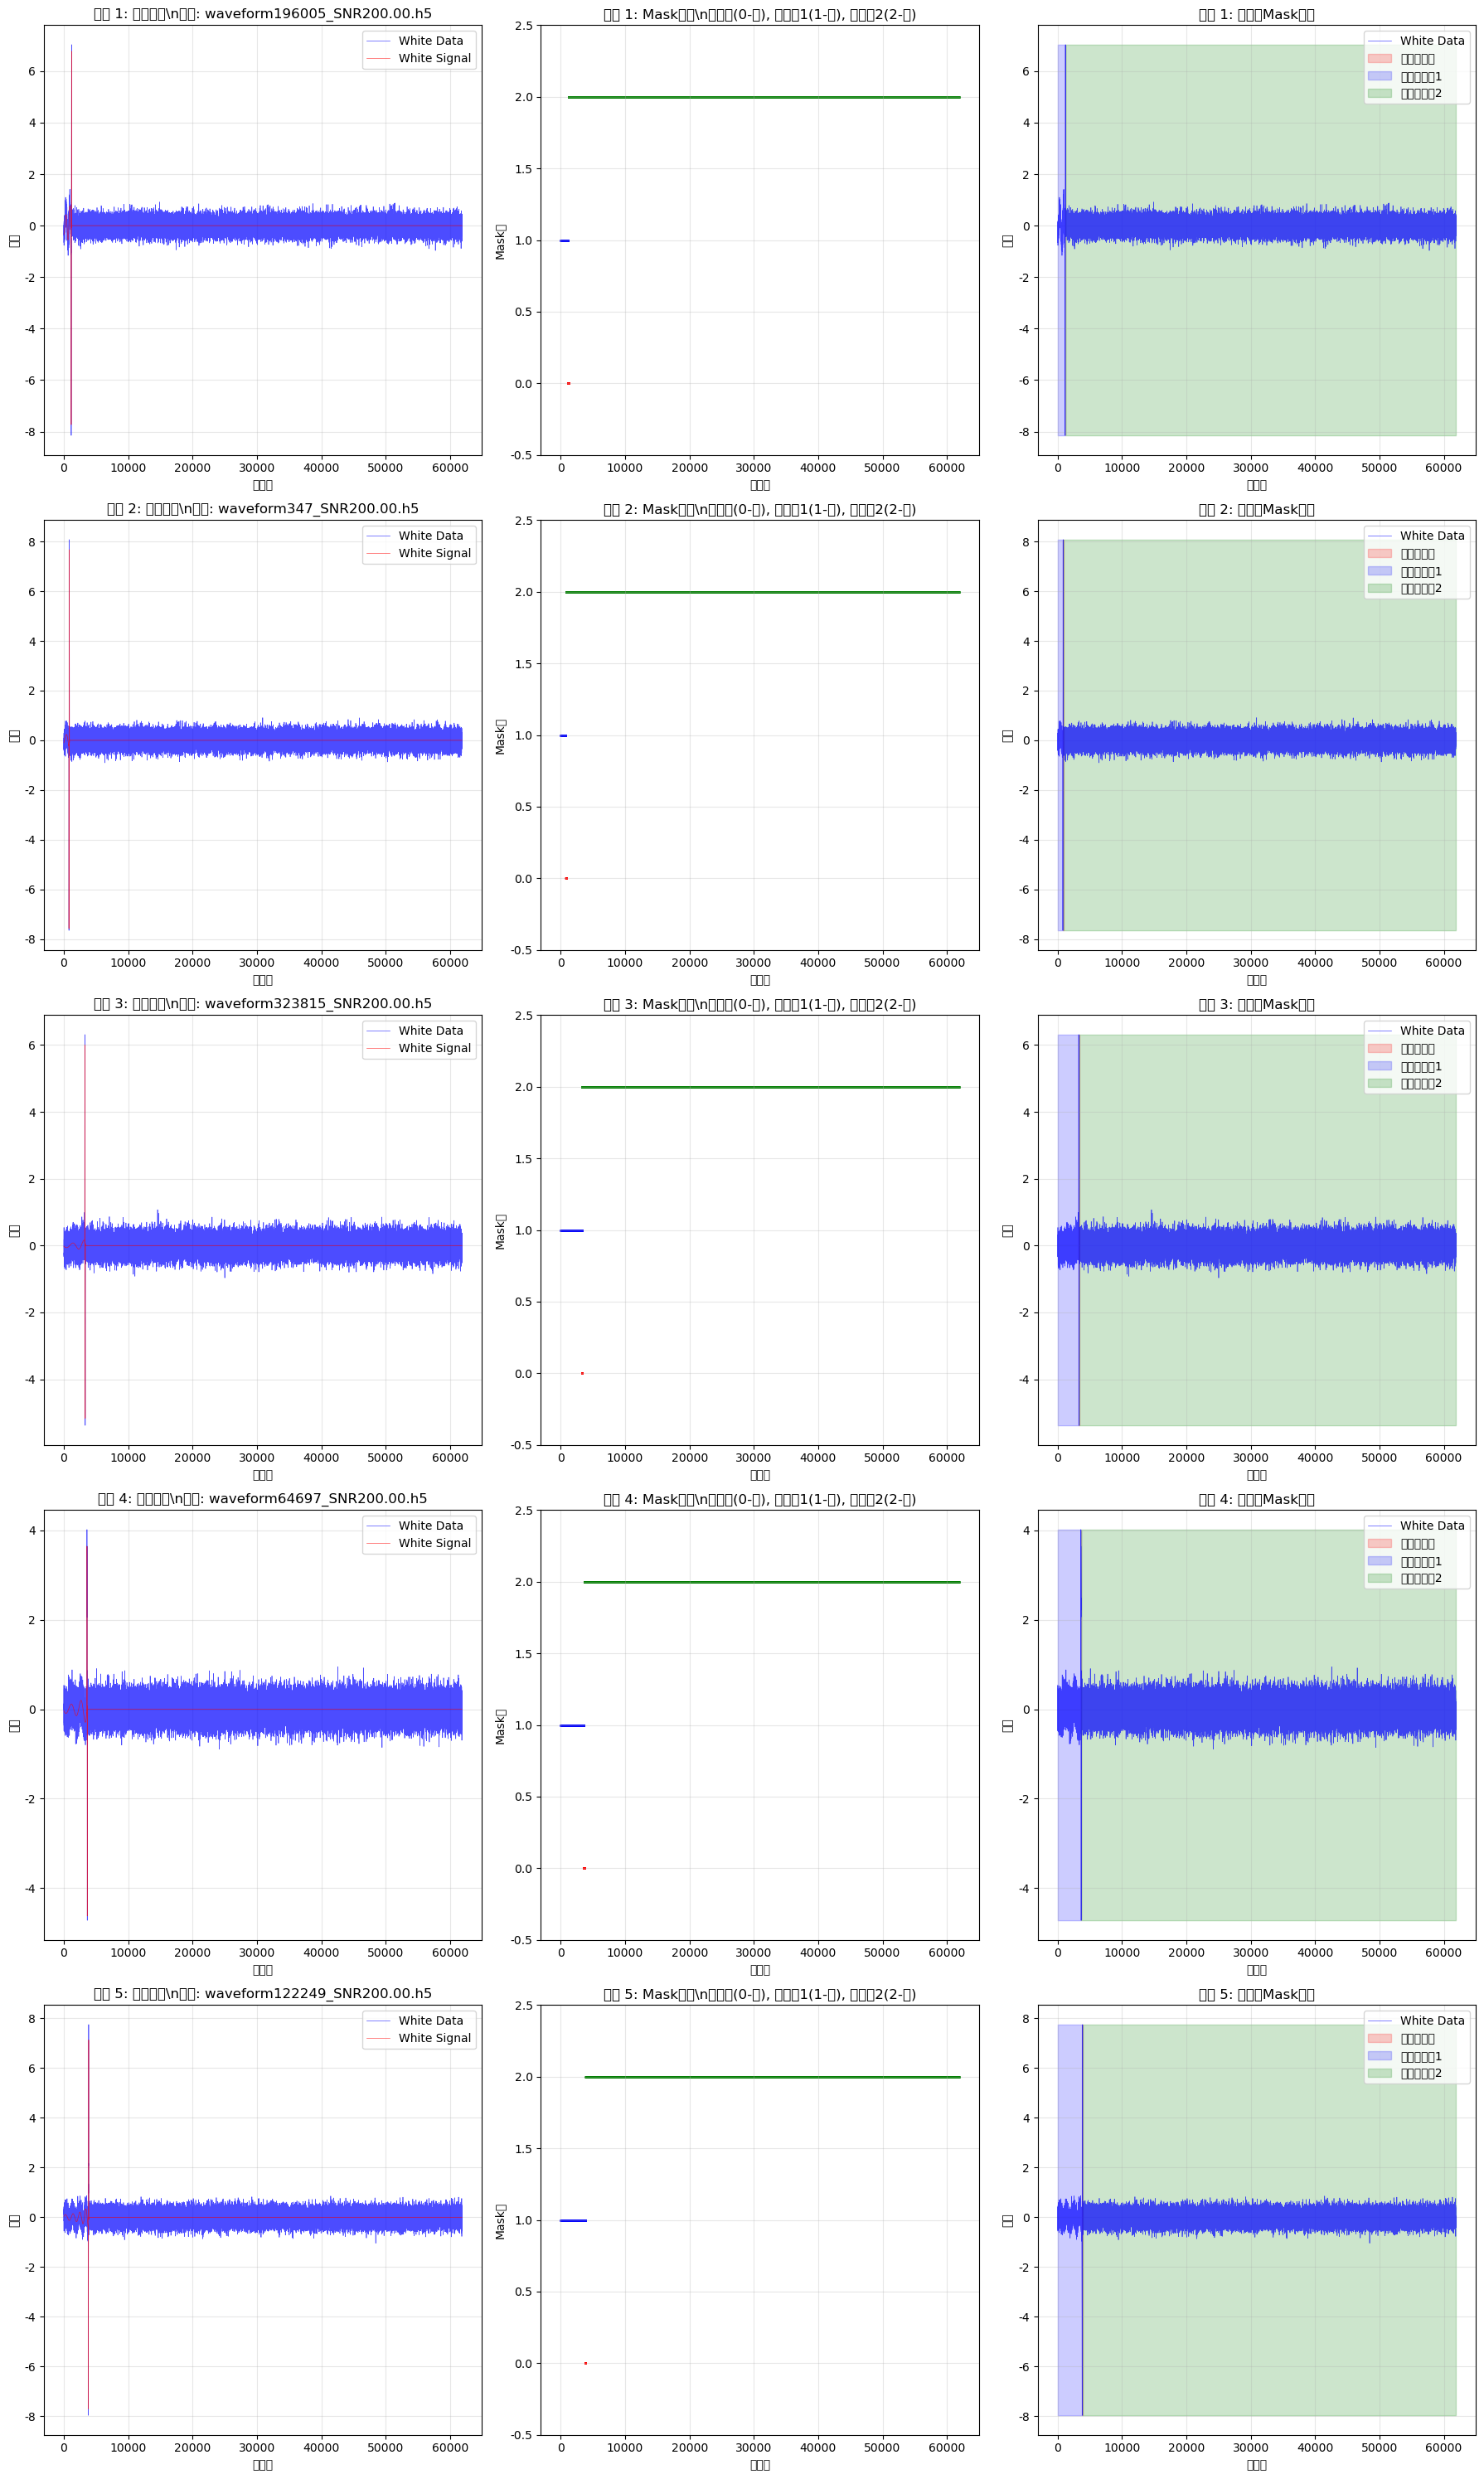

\nËØ¶ÁªÜÁªüËÆ°‰ø°ÊÅØ:
Ê†∑Êú¨ 1 (waveform196005_SNR200.00.h5):
  ÊÄªÁÇπÊï∞: 61852
  Âº±‰ø°Âè∑Âå∫Âüü1: 1132 (1.83%)
  Âº∫‰ø°Âè∑Âå∫Âüü:  81 (0.13%)
  Âº±‰ø°Âè∑Âå∫Âüü2: 60639 (98.04%)

Ê†∑Êú¨ 2 (waveform347_SNR200.00.h5):
  ÊÄªÁÇπÊï∞: 61852
  Âº±‰ø°Âè∑Âå∫Âüü1: 777 (1.26%)
  Âº∫‰ø°Âè∑Âå∫Âüü:  79 (0.13%)
  Âº±‰ø°Âè∑Âå∫Âüü2: 60996 (98.62%)

Ê†∑Êú¨ 3 (waveform323815_SNR200.00.h5):
  ÊÄªÁÇπÊï∞: 61852
  Âº±‰ø°Âè∑Âå∫Âüü1: 3254 (5.26%)
  Âº∫‰ø°Âè∑Âå∫Âüü:  79 (0.13%)
  Âº±‰ø°Âè∑Âå∫Âüü2: 58519 (94.61%)

Ê†∑Êú¨ 4 (waveform64697_SNR200.00.h5):
  ÊÄªÁÇπÊï∞: 61852
  Âº±‰ø°Âè∑Âå∫Âüü1: 3576 (5.78%)
  Âº∫‰ø°Âè∑Âå∫Âüü:  75 (0.12%)
  Âº±‰ø°Âè∑Âå∫Âüü2: 58201 (94.10%)

Ê†∑Êú¨ 5 (waveform122249_SNR200.00.h5):
  ÊÄªÁÇπÊï∞: 61852
  Âº±‰ø°Âè∑Âå∫Âüü1: 3784 (6.12%)
  Âº∫‰ø°Âè∑Âå∫Âüü:  82 (0.13%)
  Âº±‰ø°Âè∑Âå∫Âüü2: 57986 (93.75%)



In [93]:
# ÂèØËßÜÂåñmaskÁªìÊûúÁöÑÂõæÂÉè
def plot_mask_visualization(dataset, num_samples=3, threshold_factor=5.0):
    """
    ÁªòÂà∂maskÂèØËßÜÂåñÂõæÂÉè
    """
    # ÈöèÊú∫ÈÄâÊã©Ê†∑Êú¨
    total_samples = len(dataset)
    random_indices = random.sample(range(total_samples), min(num_samples, total_samples))
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(18, 6*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, idx in enumerate(random_indices):
        sample = dataset[idx]
        white_data = sample["white_data"]
        white_signal = sample["white_signal"]
        
        # ÁîüÊàêmask
        data_batch = white_data.unsqueeze(0)
        mask = generate_mask(data_batch, threshold_factor=threshold_factor)
        mask_flat = mask.squeeze(0)
        
        # ÁîªÂá∫ÊâÄÊúâÊï∞ÊçÆÁÇπ
        plot_length = len(white_data)
        x_axis = np.arange(plot_length)
        
        data_plot = white_data[:plot_length].numpy()
        signal_plot = white_signal[:plot_length].numpy()
        mask_plot = mask_flat[:plot_length].numpy()
        
        # Á¨¨‰∏Ä‰∏™Â≠êÂõæÔºöÂéüÂßãÊï∞ÊçÆ
        axes[i, 0].plot(x_axis, data_plot, 'b-', alpha=0.7, linewidth=0.5, label='White Data')
        axes[i, 0].plot(x_axis, signal_plot, 'r-', alpha=0.7, linewidth=0.5, label='White Signal')
        axes[i, 0].set_title(f'Ê†∑Êú¨ {i+1}: ÂéüÂßãÊï∞ÊçÆ\\nÊñá‰ª∂: {sample["filename"]}')
        axes[i, 0].set_xlabel('Êó∂Èó¥ÁÇπ')
        axes[i, 0].set_ylabel('ÂπÖÂÄº')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)
        
        # Á¨¨‰∫å‰∏™Â≠êÂõæÔºömaskÂàÜÂ∏É
        colors = ['red', 'blue', 'green']  # 0-Âº∫‰ø°Âè∑(Á∫¢), 1-Âº±‰ø°Âè∑1(Ëìù), 2-Âº±‰ø°Âè∑2(Áªø)
        for mask_value in [0, 1, 2]:
            mask_indices = np.where(mask_plot == mask_value)[0]
            if len(mask_indices) > 0:
                axes[i, 1].scatter(mask_indices, np.ones(len(mask_indices)) * mask_value, 
                                 c=colors[mask_value], alpha=0.6, s=0.5)
            else:
                print(f"{mask_value} does not in the data ")
        
        axes[i, 1].set_title(f'Ê†∑Êú¨ {i+1}: MaskÂàÜÂ∏É\\nÂº∫‰ø°Âè∑(0-Á∫¢), Âº±‰ø°Âè∑1(1-Ëìù), Âº±‰ø°Âè∑2(2-Áªø)')
        axes[i, 1].set_xlabel('Êó∂Èó¥ÁÇπ')
        axes[i, 1].set_ylabel('MaskÂÄº')
        axes[i, 1].set_ylim(-0.5, 2.5)
        axes[i, 1].grid(True, alpha=0.3)
        
        # Á¨¨‰∏â‰∏™Â≠êÂõæÔºöÂ∏¶maskÂå∫ÂüüÊ†áÊ≥®ÁöÑÊï∞ÊçÆ
        axes[i, 2].plot(x_axis, data_plot, 'b-', alpha=0.7, linewidth=0.5, label='White Data')
        
        # Áî®‰∏çÂêåÈ¢úËâ≤Ê†áÊ≥®‰∏çÂêåÁöÑmaskÂå∫Âüü
        for mask_value, color, label in [(0, 'red', 'Âº∫‰ø°Âè∑Âå∫Âüü'), (1, 'blue', 'Âº±‰ø°Âè∑Âå∫Âüü1'), (2, 'green', 'Âº±‰ø°Âè∑Âå∫Âüü2')]:
            mask_indices = np.where(mask_plot == mask_value)[0]
            if len(mask_indices) > 0:
                axes[i, 2].fill_between(x_axis, 
                                      np.min(data_plot), np.max(data_plot),
                                      where=(mask_plot == mask_value),
                                      alpha=0.2, color=color, label=label)
        
        axes[i, 2].set_title(f'Ê†∑Êú¨ {i+1}: Êï∞ÊçÆ‰∏éMaskÂå∫Âüü')
        axes[i, 2].set_xlabel('Êó∂Èó¥ÁÇπ')
        axes[i, 2].set_ylabel('ÂπÖÂÄº')
        axes[i, 2].legend()
        axes[i, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ËæìÂá∫ÁªüËÆ°‰ø°ÊÅØ
    print("\\nËØ¶ÁªÜÁªüËÆ°‰ø°ÊÅØ:")
    print("=" * 60)
    for i, idx in enumerate(random_indices):
        sample = dataset[idx]
        white_data = sample["white_data"]
        data_batch = white_data.unsqueeze(0)
        mask = generate_mask(data_batch, threshold_factor=threshold_factor)
        mask_flat = mask.squeeze(0)
        
        weak_1_count = (mask_flat == 1).sum().item()
        strong_count = (mask_flat == 0).sum().item()
        weak_2_count = (mask_flat == 2).sum().item()
        total_points = len(mask_flat)
        
        print(f"Ê†∑Êú¨ {i+1} ({sample['filename']}):")
        print(f"  ÊÄªÁÇπÊï∞: {total_points}")
        print(f"  Âº±‰ø°Âè∑Âå∫Âüü1: {weak_1_count} ({weak_1_count/total_points*100:.2f}%)")
        print(f"  Âº∫‰ø°Âè∑Âå∫Âüü:  {strong_count} ({strong_count/total_points*100:.2f}%)")
        print(f"  Âº±‰ø°Âè∑Âå∫Âüü2: {weak_2_count} ({weak_2_count/total_points*100:.2f}%)")
        print()

# ÁªòÂà∂maskÂèØËßÜÂåñÂõæÂÉè
print("\\nÁªòÂà∂maskÂèØËßÜÂåñÂõæÂÉè...")
plot_mask_visualization(train_set, num_samples=5)

ÊµãËØï‰∏çÂêåthreshold_factorÂØπmaskÁªìÊûúÁöÑÂΩ±Âìç...
ÊµãËØïÊ†∑Êú¨: waveform2861_SNR200.00.h5
Êï∞ÊçÆÈïøÂ∫¶: 61852
Threshold Factor: 2.0
  Âº±‰ø°Âè∑Âå∫Âüü1: 56 (0.09%)
  Âº∫‰ø°Âè∑Âå∫Âüü:  61773 (99.87%)
  Âº±‰ø°Âè∑Âå∫Âüü2: 23 (0.04%)
  Âº∫‰ø°Âè∑ËåÉÂõ¥: [56, 61828] (ÈïøÂ∫¶: 61773)

Threshold Factor: 2.5
  Âº±‰ø°Âè∑Âå∫Âüü1: 620 (1.00%)
  Âº∫‰ø°Âè∑Âå∫Âüü:  60437 (97.71%)
  Âº±‰ø°Âè∑Âå∫Âüü2: 795 (1.29%)
  Âº∫‰ø°Âè∑ËåÉÂõ¥: [620, 61056] (ÈïøÂ∫¶: 60437)

Threshold Factor: 3.0
  Âº±‰ø°Âè∑Âå∫Âüü1: 1583 (2.56%)
  Âº∫‰ø°Âè∑Âå∫Âüü:  54799 (88.60%)
  Âº±‰ø°Âè∑Âå∫Âüü2: 5470 (8.84%)
  Âº∫‰ø°Âè∑ËåÉÂõ¥: [1583, 56381] (ÈïøÂ∫¶: 54799)

Threshold Factor: 3.5
  Âº±‰ø°Âè∑Âå∫Âüü1: 1583 (2.56%)
  Âº∫‰ø°Âè∑Âå∫Âüü:  49502 (80.03%)
  Âº±‰ø°Âè∑Âå∫Âüü2: 10767 (17.41%)
  Âº∫‰ø°Âè∑ËåÉÂõ¥: [1583, 51084] (ÈïøÂ∫¶: 49502)

Threshold Factor: 4.0
  Âº±‰ø°Âè∑Âå∫Âüü1: 1583 (2.56%)
  Âº∫‰ø°Âè∑Âå∫Âüü:  82 (0.13%)
  Âº±‰ø°Âè∑Âå∫Âüü2: 60187 (97.31%)
  Âº∫‰ø°Âè∑ËåÉÂõ¥: [1583, 1664] (ÈïøÂ∫¶: 82)

Threshold Factor: 4.5
  Âº±‰ø°Âè∑Â

/tmp/ipykernel_14833/1534068089.py:78: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_14833/1534068089.py:78: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_14833/1534068089.py:78: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_14833/1534068089.py:78: UserWarning: Glyph 24133 (\N{CJK UNIFIED IDEOGRAPH-5E45}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_14833/1534068089.py:78: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_14833/1534068089.py:78: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_14833/1534068089.py:78: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  plt.

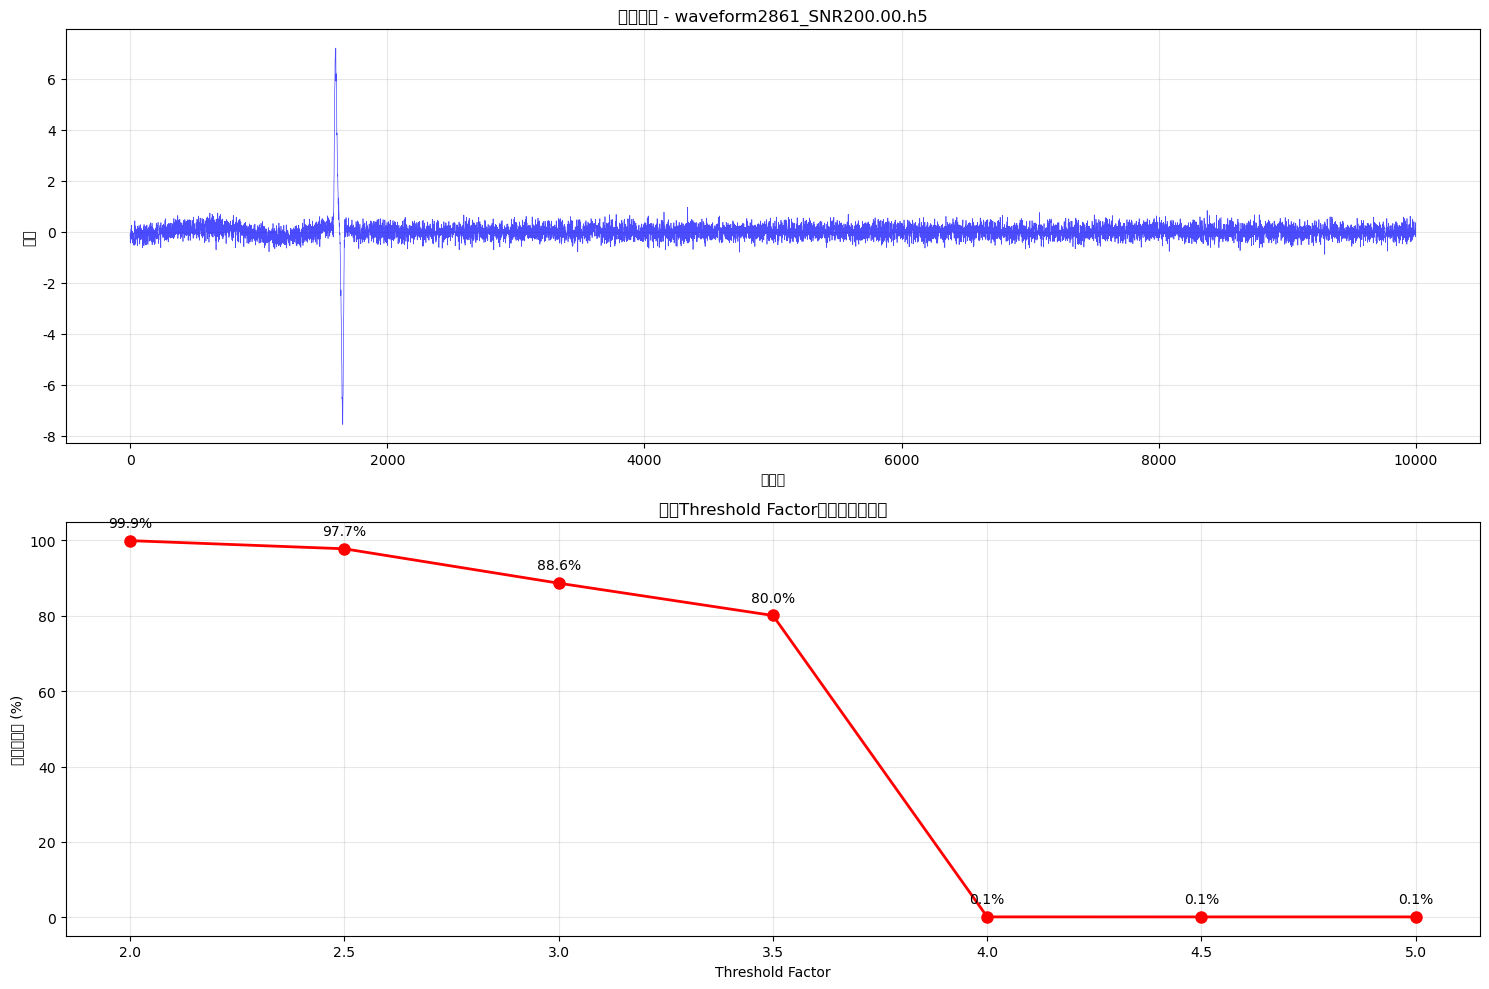

In [20]:
# ÊµãËØï‰∏çÂêåthreshold_factorÂØπmaskÁªìÊûúÁöÑÂΩ±Âìç
def test_threshold_effects(dataset, sample_idx=0, threshold_factors=[2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5]):
    """
    ÊµãËØï‰∏çÂêåthreshold_factorÂØπmaskÁªìÊûúÁöÑÂΩ±Âìç
    """
    sample = dataset[sample_idx]
    white_data = sample["white_data"]
    data_batch = white_data.unsqueeze(0)
    
    print(f"ÊµãËØïÊ†∑Êú¨: {sample['filename']}")
    print(f"Êï∞ÊçÆÈïøÂ∫¶: {len(white_data)}")
    print("=" * 80)
    
    results = []
    for threshold_factor in threshold_factors:
        mask = generate_mask(data_batch, threshold_factor=threshold_factor)
        mask_flat = mask.squeeze(0)
        
        weak_1_count = (mask_flat == 1).sum().item()
        strong_count = (mask_flat == 0).sum().item()
        weak_2_count = (mask_flat == 2).sum().item()
        total_points = len(mask_flat)
        
        results.append({
            'threshold_factor': threshold_factor,
            'weak_1': weak_1_count,
            'strong': strong_count,
            'weak_2': weak_2_count,
            'total': total_points
        })
        
        print(f"Threshold Factor: {threshold_factor}")
        print(f"  Âº±‰ø°Âè∑Âå∫Âüü1: {weak_1_count} ({weak_1_count/total_points*100:.2f}%)")
        print(f"  Âº∫‰ø°Âè∑Âå∫Âüü:  {strong_count} ({strong_count/total_points*100:.2f}%)")
        print(f"  Âº±‰ø°Âè∑Âå∫Âüü2: {weak_2_count} ({weak_2_count/total_points*100:.2f}%)")
        
        # ÊâæÂà∞Âº∫‰ø°Âè∑ÁöÑËåÉÂõ¥
        strong_indices = torch.nonzero(mask_flat == 0).squeeze()
        if strong_indices.numel() > 0:
            if strong_indices.dim() == 0:
                strong_start = strong_end = strong_indices.item()
            else:
                strong_start = strong_indices[0].item()
                strong_end = strong_indices[-1].item()
            print(f"  Âº∫‰ø°Âè∑ËåÉÂõ¥: [{strong_start}, {strong_end}] (ÈïøÂ∫¶: {strong_end - strong_start + 1})")
        else:
            print(f"  Âº∫‰ø°Âè∑ËåÉÂõ¥: Êó†")
        print()
    
    # ÂèØËßÜÂåñ‰∏çÂêåthresholdÁöÑÊïàÊûú
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # ÁªòÂà∂ÂéüÂßãÊï∞ÊçÆ
    plot_length = min(10000, len(white_data))
    x_axis = np.arange(plot_length)
    data_plot = white_data[:plot_length].numpy()
    
    ax1.plot(x_axis, data_plot, 'b-', alpha=0.7, linewidth=0.5)
    ax1.set_title(f'ÂéüÂßãÊï∞ÊçÆ - {sample["filename"]}')
    ax1.set_xlabel('Êó∂Èó¥ÁÇπ')
    ax1.set_ylabel('ÂπÖÂÄº')
    ax1.grid(True, alpha=0.3)
    
    # ÁªòÂà∂‰∏çÂêåthreshold‰∏ãÁöÑÂº∫‰ø°Âè∑ÊØî‰æã
    thresholds = [r['threshold_factor'] for r in results]
    strong_percentages = [r['strong']/r['total']*100 for r in results]
    
    ax2.plot(thresholds, strong_percentages, 'ro-', linewidth=2, markersize=8)
    ax2.set_title('‰∏çÂêåThreshold Factor‰∏ãÁöÑÂº∫‰ø°Âè∑ÊØî‰æã')
    ax2.set_xlabel('Threshold Factor')
    ax2.set_ylabel('Âº∫‰ø°Âè∑ÊØî‰æã (%)')
    ax2.grid(True, alpha=0.3)
    
    # Ê∑ªÂä†Êï∞ÂÄºÊ†áÁ≠æ
    for i, (t, p) in enumerate(zip(thresholds, strong_percentages)):
        ax2.annotate(f'{p:.1f}%', (t, p), textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.tight_layout()
    plt.show()

# ÊµãËØï‰∏çÂêåthreshold_factorÁöÑÊïàÊûú
print("ÊµãËØï‰∏çÂêåthreshold_factorÂØπmaskÁªìÊûúÁöÑÂΩ±Âìç...")
test_threshold_effects(train_set, sample_idx=10)

In [104]:
%%time
# ËÆ≠ÁªÉ
train_model(denoising_model, train_loader, val_loader, optimizer, device, num_epochs=200)
# train_model_amp(denoising_model, train_loader, val_loader, optimizer, device, num_epochs=120)

1/200: Train Loss = 3.150546, Val Loss = 1.536345, Output Std = 0.4446, LR = 1.00e-05
  >> Best model saved.
2/200: Train Loss = 1.533517, Val Loss = 1.526963, Output Std = 0.4430, LR = 1.00e-05
  >> Best model saved.
3/200: Train Loss = 1.527171, Val Loss = 1.524898, Output Std = 0.4455, LR = 1.00e-05
  >> Best model saved.
4/200: Train Loss = 1.523715, Val Loss = 1.527497, Output Std = 0.4468, LR = 1.00e-05
5/200: Train Loss = 1.520398, Val Loss = 1.517993, Output Std = 0.4425, LR = 1.00e-05
  >> Best model saved.
6/200: Train Loss = 1.519047, Val Loss = 1.531615, Output Std = 0.4484, LR = 1.00e-05
7/200: Train Loss = 1.517396, Val Loss = 1.515330, Output Std = 0.4449, LR = 1.00e-05
  >> Best model saved.
8/200: Train Loss = 1.515499, Val Loss = 1.516011, Output Std = 0.4457, LR = 1.00e-05
9/200: Train Loss = 1.513712, Val Loss = 1.512409, Output Std = 0.4437, LR = 1.00e-05
  >> Best model saved.
10/200: Train Loss = 1.512773, Val Loss = 1.520198, Output Std = 0.4477, LR = 1.00e-05
1

In [12]:
# ÊµãËØï
def test_model_and_save_labels_batched(model, test_loader, device, output_dir="pt_chunks", base_name="denoised_batch", target_names=["mc_true", "phis_true", "thetas_true"]):
    os.makedirs(output_dir, exist_ok=True)
    model.eval()
    batch_count = 0

    with torch.no_grad():
        for batch in test_loader:
            white_data = batch["white_data"].to(device)
            mask = generate_mask(white_data).unsqueeze(1).to(device)
            x = white_data.unsqueeze(1)

            # Ê†áÂáÜÂåñÂ§ÑÁêÜ
            x_std, _, _ = standardize_batch(x.squeeze(1), x.squeeze(1), mask.squeeze(1))
            x_std = x_std.unsqueeze(1).to(device)

            # ÂéªÂô™ËæìÂá∫
            output = model(x_std, mask).cpu()

            # ÊèêÂèñ‰∏âÁ±ªÊ†áÁ≠æÂπ∂ÁªÑÂêà‰∏∫ (B, 3)
            mc = torch.tensor(batch["mc_true"], dtype=torch.float32).view(-1, 1)
            phis = torch.tensor(batch["phis_true"], dtype=torch.float32).view(-1, 1)
            thetas = torch.tensor(batch["thetas_true"], dtype=torch.float32).view(-1, 1)
            targets = torch.cat([mc, phis, thetas], dim=1)

            # ‰øùÂ≠òÊñá‰ª∂
            file_path = os.path.join(output_dir, f"{base_name}_{batch_count:04d}.pt")
            torch.save({
                "denoised": output,
                "targets": targets,
                "target_names": target_names
            }, file_path)
            
            torch.cuda.empty_cache()  # ‰øùÂ≠òÂêéÁ´ãÂç≥ÈáäÊîæÁºìÂ≠ò

            print(f"[Saved] {file_path} ‚Üê {output.shape[0]} samples")
            batch_count += 1

    print(f"[Done] ÂÖ±‰øùÂ≠ò {batch_count} ‰∏™ÊâπÊ¨°Êñá‰ª∂‰∫é: {output_dir}")

In [13]:
def selective_inverse_transform(signal, mask, stats, amplification=10.0):
    signal = signal.copy()
    signal = signal * stats["iqr"] + stats["median"]  # ÊâÄÊúâÂå∫ÂüüÂèçÊ†áÂáÜÂåñ
    signal[mask == 1] /= amplification                # ‰ªÖÂº±‰ø°Âè∑ÂÜçÈô§‰ª•ÊîæÂ§ßÂÄçÊï∞
    return signal

# ÂèØËßÜÂåñÂéªÂô™ÊïàÊûúÔºàËæìÂÖ•„ÄÅÈ¢ÑÊµã„ÄÅÁ∫Ø‰ø°Âè∑Ôºâ
def visualize_denoising_subplots(model, test_loader, device, sample_index=0):
    model.eval()
    with torch.no_grad():
        batch = next(iter(test_loader))
        white_data = batch["white_data"].to(device)
        white_signal = batch["white_signal"].to(device)
        mask = generate_mask(white_data).unsqueeze(1).to(device)
        print(mask[sample_index])

        x = white_data.unsqueeze(1)
        y = white_signal.unsqueeze(1)

        # Ê†áÂáÜÂåñ + Ëé∑ÂèñÁªüËÆ°Èáè
        x_std, y_std, stats = standardize_batch(x.squeeze(1), y.squeeze(1), mask.squeeze(1))
        x_std = x_std.unsqueeze(1).to(device)
        y_std = y_std.unsqueeze(1).to(device)

        output = model(x_std, mask).squeeze(1).cpu().numpy()
        print(output[sample_index])

    # ÈÄâÊã©Ê†∑Êú¨
    input_signal = x[sample_index].squeeze().cpu().numpy()
    denoised_signal = output[sample_index]
    clean_signal = y[sample_index].squeeze().cpu().numpy()
    signal_mask = mask[sample_index].squeeze().cpu().numpy()

    # ÂèçÂΩí‰∏ÄÂåñ
    input_signal = selective_inverse_transform(input_signal, signal_mask, stats, amplification=1.0)
    denoised_signal = selective_inverse_transform(denoised_signal, signal_mask, stats, amplification=1.0)
    clean_signal = selective_inverse_transform(clean_signal, signal_mask, stats, amplification=1.0)

    # ÁªòÂõæ
    fig, axs = plt.subplots(3, 1, figsize=(15, 9), sharex=True)
    axs[0].plot(input_signal, color='orange')
    axs[0].set_title("Noisy Input")
    axs[1].plot(denoised_signal, color='green')
    axs[1].set_title("Denoised Output")
    axs[2].plot(clean_signal, color='blue')
    axs[2].set_title("Ground Truth Signal")

    for ax in axs:
        # ax.set_ylim(-1, 1)
        ax.grid(True)
    plt.tight_layout()
    plt.show()

## È¢ÑÊµã

In [ ]:
class LazyDenoisedDataset(Dataset):
    def __init__(self, chunk_folder, label_idx=0):
        self.chunk_paths = sorted([
            os.path.join(chunk_folder, f)
            for f in os.listdir(chunk_folder)
            if f.endswith(".pt")
        ])
        self.label_idx = label_idx
        self.index_map = []

        # È¢ÑÂÖàÊûÑÂª∫ (file_id, local_id) Êò†Â∞ÑË°®
        for file_idx, file_path in enumerate(self.chunk_paths):
            data = torch.load(file_path, map_location="cpu")
            count = data["denoised"].shape[0]
            self.index_map.extend([(file_idx, i) for i in range(count)])

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        file_idx, local_idx = self.index_map[idx]
        file_path = self.chunk_paths[file_idx]
        data = torch.load(file_path, map_location="cpu")

        signal = data["denoised"][local_idx].float()     # shape: (1, L)
        label = data["targets"][local_idx, self.label_idx].unsqueeze(0).float()  # shape: (1,)

        return {"signal": signal, "label": label}

In [ ]:
def train_mc_model(model, train_loader, val_loader, optimizer, scaler, device, num_epochs=150):
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

    model.to(device)
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            x = batch["signal"].to(device)  # (B, 1, L)
            y = batch["label"].to(device)   # (B, 1)

            # ÂΩí‰∏ÄÂåñÊ†áÁ≠æ
            y_scaled = scaler.transform(y.cpu().numpy())
            y_scaled = torch.tensor(y_scaled, dtype=torch.float32).to(device)

            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y_scaled)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)

        avg_train_loss = total_loss / len(train_loader.dataset)

        # ===== È™åËØÅ =====
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                x = batch["signal"].to(device)
                y = batch["label"].to(device)
                y_scaled = scaler.transform(y.cpu().numpy())
                y_scaled = torch.tensor(y_scaled, dtype=torch.float32).to(device)
                pred = model(x)
                loss = criterion(pred, y_scaled)
                val_loss += loss.item() * x.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)
        scheduler.step(avg_val_loss)

        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_model_Mc.pt")
            print(">> Best model saved.")

In [ ]:
# Ê∑∑ÂêàÁ≤æÂ∫¶ËÆ≠ÁªÉ
def train_mc_model_amp(model, train_loader, val_loader, optimizer, scaler, device, num_epochs=150):
    model.to(device)
    loss_fn = nn.MSELoss()
    amp_scaler = GradScaler()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for batch in train_loader:
            x = batch["signal"].to(device, non_blocking=True)
            y = batch["label"].cpu().numpy()
            y_scaled = scaler.transform(y)
            y_scaled = torch.tensor(y_scaled, dtype=torch.float32).to(device)

            optimizer.zero_grad()

            with autocast():
                pred = model(x)
                loss = loss_fn(pred, y_scaled)

            amp_scaler.scale(loss).backward()
            amp_scaler.step(optimizer)
            amp_scaler.update()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # === È™åËØÅÈò∂ÊÆµ ===
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                x = batch["signal"].to(device, non_blocking=True)
                y = batch["label"].cpu().numpy()
                y_scaled = scaler.transform(y)
                y_scaled = torch.tensor(y_scaled, dtype=torch.float32).to(device)

                with autocast():
                    pred = model(x)
                    loss = loss_fn(pred, y_scaled)

                val_loss += loss.item()

        val_loss /= len(val_loader)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model_Mc.pt")

In [ ]:
def evaluate_mc_model(model, test_loader, scaler, device):
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for batch in test_loader:
            x = batch["signal"].to(device)
            y = batch["label"].cpu().numpy()
            pred = model(x).cpu().numpy()
            preds.append(pred)
            trues.append(y)

    preds = scaler.inverse_transform(np.vstack(preds)).flatten()
    trues = np.vstack(trues).flatten()

    # === ËæìÂá∫ËØÑ‰º∞ÊåáÊ†á ===
    mse = mean_squared_error(trues, preds)
    r2 = r2_score(trues, preds)
    print("Test MSE:", mse)
    print("Test R¬≤ :", r2)

    # === Êï£ÁÇπÂõæ ===
    plt.figure(figsize=(6, 6))
    plt.scatter(trues, preds, alpha=0.5)
    plt.plot([trues.min(), trues.max()], [trues.min(), trues.max()], 'r--')
    plt.xlabel("True Value")
    plt.ylabel("Predicted Value")
    plt.title("Prediction Scatter Plot")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === ËØØÂ∑ÆÁõ¥ÊñπÂõæ ===
    errors = preds - trues
    plt.figure(figsize=(6, 4))
    plt.hist(errors, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    plt.axvline(x=0, color='red', linestyle='--', label='Zero Error')
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.title("Prediction Error Histogram")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Violin Plot ===
    data = pd.DataFrame({
        "Type": ["True"] * len(trues) + ["Predicted"] * len(preds),
        "Value": np.concatenate([trues, preds])
    })

    plt.figure(figsize=(6, 5))
    sns.violinplot(x="Type", y="Value", data=data, inner="quartile", palette="muted")
    plt.title("Distribution of True vs Predicted Values")
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

In [ ]:
# ---------- ÂèÇÊï∞ÈÖçÁΩÆ ----------
chunk_dir = "pt_chunks"         # ÂàÜÊâπ‰øùÂ≠òÁöÑ .pt Êñá‰ª∂Ë∑ØÂæÑ
label_idx = 0                   # 0=mc_true, 1=phis_true, 2=thetas_true
batch_size = 16
model_save_path = "best_model_Mc.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- ÊûÑÂª∫Êï∞ÊçÆÈõÜ ----------
dataset = LazyDenoisedDataset(chunk_dir, label_idx=label_idx)
print(f"[INFO] Ê†∑Êú¨ÊÄªÊï∞: {len(dataset)}")

# ---------- ÊèêÂèñÊâÄÊúâÊ†áÁ≠æËøõË°åÂΩí‰∏ÄÂåñ ----------
all_labels = torch.stack([dataset[i]["label"] for i in range(len(dataset))])
label_scaler = StandardScaler()
label_scaler.fit(all_labels.numpy())

# ---------- Êï∞ÊçÆÂàíÂàÜ ----------
n = len(dataset)
train_len = int(n * 0.6)
val_len = int(n * 0.2)
test_len = n - train_len - val_len
train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=batch_size)
test_loader  = DataLoader(test_set, batch_size=batch_size)

# ---------- ÂàùÂßãÂåñÊ®°Âûã ----------
model = ResNetModel()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# ---------- ËÆ≠ÁªÉ ----------
train_mc_model(model, train_loader, val_loader, optimizer, label_scaler, device)
# train_mc_model_amp(pred_model, train_loader, val_loader, optimizer, label_scaler, device)

# ---------- ÊµãËØï ----------
model.load_state_dict(torch.load(model_save_path))
evaluate_mc_model(model, test_loader, label_scaler, device)

# Train with Checkpoints

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
print(device)

cuda


In [16]:
## ÂÆåÊï¥ÁöÑÊ®°Âûã‰øùÂ≠òÂíåÂä†ËΩΩÁ≥ªÁªü

import json
import os
from datetime import datetime

class ModelCheckpoint:
    """ÂÆåÊï¥ÁöÑÊ®°ÂûãÊ£ÄÊü•ÁÇπ‰øùÂ≠òÂíåÂä†ËΩΩÁ≥ªÁªü"""
    
    def __init__(self, save_dir="checkpoints"):
        """
        ÂàùÂßãÂåñÊ®°ÂûãÊ£ÄÊü•ÁÇπÁÆ°ÁêÜÂô®
        Args:
            save_dir: ‰øùÂ≠òÊ£ÄÊü•ÁÇπÁöÑÁõÆÂΩï
        """
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
    
    def save_checkpoint(self, model, optimizer, scheduler, epoch, train_loss, val_loss, 
                       best_val_loss, model_config=None, training_config=None, 
                       checkpoint_name=None):
        """
        ‰øùÂ≠òÂÆåÊï¥ÁöÑÊ®°ÂûãÊ£ÄÊü•ÁÇπ
        Args:
            model: Ê®°ÂûãÂÆû‰æã
            optimizer: ‰ºòÂåñÂô®
            scheduler: Â≠¶‰π†ÁéáË∞ÉÂ∫¶Âô®
            epoch: ÂΩìÂâçËΩÆÊ¨°
            train_loss: ËÆ≠ÁªÉÊçüÂ§±
            val_loss: È™åËØÅÊçüÂ§±
            best_val_loss: ÊúÄ‰Ω≥È™åËØÅÊçüÂ§±
            model_config: Ê®°ÂûãÈÖçÁΩÆÂ≠óÂÖ∏
            training_config: ËÆ≠ÁªÉÈÖçÁΩÆÂ≠óÂÖ∏
            checkpoint_name: Ê£ÄÊü•ÁÇπÂêçÁß∞ÔºåÂ¶ÇÊûú‰∏∫NoneÂàôËá™Âä®ÁîüÊàê
        """
        if checkpoint_name is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            checkpoint_name = f"checkpoint_epoch_{epoch}_{timestamp}.pt"
        
        checkpoint_path = os.path.join(self.save_dir, checkpoint_name)
        
        # ÂáÜÂ§á‰øùÂ≠òÁöÑÊï∞ÊçÆ
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'best_val_loss': best_val_loss,
            'timestamp': datetime.now().isoformat(),
            'model_config': model_config or {},
            'training_config': training_config or {}
        }
        
        # ‰øùÂ≠òÊ£ÄÊü•ÁÇπ
        torch.save(checkpoint, checkpoint_path)
        
        # ‰øùÂ≠òÂÖÉÊï∞ÊçÆÂà∞JSONÊñá‰ª∂Ôºà‰æø‰∫éÊü•ÁúãÔºâ
        metadata = {
            'checkpoint_name': checkpoint_name,
            'epoch': epoch,
            'train_loss': float(train_loss),
            'val_loss': float(val_loss),
            'best_val_loss': float(best_val_loss),
            'timestamp': checkpoint['timestamp'],
            'model_config': model_config or {},
            'training_config': training_config or {}
        }
        
        metadata_path = os.path.join(self.save_dir, checkpoint_name.replace('.pt', '_metadata.json'))
        with open(metadata_path, 'w', encoding='utf-8') as f:
            json.dump(metadata, f, indent=2, ensure_ascii=False)
        
        print(f"‚úÖ Ê£ÄÊü•ÁÇπÂ∑≤‰øùÂ≠ò: {checkpoint_path}")
        return checkpoint_path
    
    def load_checkpoint(self, checkpoint_path, model, optimizer=None, scheduler=None, device='cpu'):
        """
        Âä†ËΩΩÊ®°ÂûãÊ£ÄÊü•ÁÇπ
        Args:
            checkpoint_path: Ê£ÄÊü•ÁÇπÊñá‰ª∂Ë∑ØÂæÑ
            model: Ê®°ÂûãÂÆû‰æã
            optimizer: ‰ºòÂåñÂô®ÔºàÂèØÈÄâÔºâ
            scheduler: Â≠¶‰π†ÁéáË∞ÉÂ∫¶Âô®ÔºàÂèØÈÄâÔºâ
            device: ËÆæÂ§á
        Returns:
            dict: ÂåÖÂê´Âä†ËΩΩ‰ø°ÊÅØÁöÑÂ≠óÂÖ∏
        """
        if not os.path.exists(checkpoint_path):
            raise FileNotFoundError(f"Ê£ÄÊü•ÁÇπÊñá‰ª∂‰∏çÂ≠òÂú®: {checkpoint_path}")
        
        print(f"üìÇ Ê≠£Âú®Âä†ËΩΩÊ£ÄÊü•ÁÇπ: {checkpoint_path}")
        
        # Âä†ËΩΩÊ£ÄÊü•ÁÇπ
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        
        # Âä†ËΩΩÊ®°ÂûãÁä∂ÊÄÅ
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Âä†ËΩΩ‰ºòÂåñÂô®Áä∂ÊÄÅÔºàÂ¶ÇÊûúÊèê‰æõÔºâ
        if optimizer and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print("‚úÖ ‰ºòÂåñÂô®Áä∂ÊÄÅÂ∑≤Âä†ËΩΩ")
        
        # Âä†ËΩΩË∞ÉÂ∫¶Âô®Áä∂ÊÄÅÔºàÂ¶ÇÊûúÊèê‰æõÔºâ
        if scheduler and 'scheduler_state_dict' in checkpoint and checkpoint['scheduler_state_dict']:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            print("‚úÖ Â≠¶‰π†ÁéáË∞ÉÂ∫¶Âô®Áä∂ÊÄÅÂ∑≤Âä†ËΩΩ")
        
        # ÊèêÂèñËÆ≠ÁªÉ‰ø°ÊÅØ
        loaded_info = {
            'epoch': checkpoint.get('epoch', 0),
            'train_loss': checkpoint.get('train_loss', float('inf')),
            'val_loss': checkpoint.get('val_loss', float('inf')),
            'best_val_loss': checkpoint.get('best_val_loss', float('inf')),
            'timestamp': checkpoint.get('timestamp', 'unknown'),
            'model_config': checkpoint.get('model_config', {}),
            'training_config': checkpoint.get('training_config', {})
        }
        
        print(f"‚úÖ Ê£ÄÊü•ÁÇπÂä†ËΩΩÂÆåÊàê!")
        print(f"   - ËΩÆÊ¨°: {loaded_info['epoch']}")
        print(f"   - È™åËØÅÊçüÂ§±: {loaded_info['val_loss']:.6f}")
        print(f"   - ÊúÄ‰Ω≥È™åËØÅÊçüÂ§±: {loaded_info['best_val_loss']:.6f}")
        print(f"   - ‰øùÂ≠òÊó∂Èó¥: {loaded_info['timestamp']}")
        
        return loaded_info
    
    def save_best_model(self, model, val_loss, model_name="best_model.pt"):
        """
        ‰øùÂ≠òÊúÄ‰Ω≥Ê®°ÂûãÔºàÂè™‰øùÂ≠òÊ®°ÂûãÊùÉÈáçÔºâ
        Args:
            model: Ê®°ÂûãÂÆû‰æã
            val_loss: È™åËØÅÊçüÂ§±
            model_name: Ê®°ÂûãÊñá‰ª∂Âêç
        """
        model_path = os.path.join(self.save_dir, model_name)
        torch.save({
            'model_state_dict': model.state_dict(),
            'val_loss': val_loss,
            'timestamp': datetime.now().isoformat()
        }, model_path)
        print(f"üèÜ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: {model_path} (È™åËØÅÊçüÂ§±: {val_loss:.6f})")
        return model_path
    
    def load_best_model(self, model, model_name="best_model.pt", device='cpu'):
        """
        Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã
        Args:
            model: Ê®°ÂûãÂÆû‰æã
            model_name: Ê®°ÂûãÊñá‰ª∂Âêç
            device: ËÆæÂ§á
        """
        model_path = os.path.join(self.save_dir, model_name)
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂‰∏çÂ≠òÂú®: {model_path}")
        
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        print(f"üèÜ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤Âä†ËΩΩ: {model_path}")
        if 'val_loss' in checkpoint:
            print(f"   - È™åËØÅÊçüÂ§±: {checkpoint['val_loss']:.6f}")
        if 'timestamp' in checkpoint:
            print(f"   - ‰øùÂ≠òÊó∂Èó¥: {checkpoint['timestamp']}")
    
    def list_checkpoints(self):
        """ÂàóÂá∫ÊâÄÊúâÂèØÁî®ÁöÑÊ£ÄÊü•ÁÇπ"""
        checkpoints = []
        for file in os.listdir(self.save_dir):
            if file.endswith('.pt') and not file.startswith('best_'):
                metadata_file = file.replace('.pt', '_metadata.json')
                metadata_path = os.path.join(self.save_dir, metadata_file)
                
                if os.path.exists(metadata_path):
                    with open(metadata_path, 'r', encoding='utf-8') as f:
                        metadata = json.load(f)
                    checkpoints.append(metadata)
                else:
                    # Â¶ÇÊûúÊ≤°ÊúâÂÖÉÊï∞ÊçÆÊñá‰ª∂ÔºåÂè™ÊòæÁ§∫Êñá‰ª∂Âêç
                    checkpoints.append({'checkpoint_name': file, 'epoch': 'unknown'})
        
        # ÊåâËΩÆÊ¨°ÊéíÂ∫è
        checkpoints.sort(key=lambda x: x.get('epoch', 0))
        return checkpoints
    
    def cleanup_old_checkpoints(self, keep_last_n=5):
        """
        Ê∏ÖÁêÜÊóßÁöÑÊ£ÄÊü•ÁÇπÔºåÂè™‰øùÁïôÊúÄËøëÁöÑN‰∏™
        Args:
            keep_last_n: ‰øùÁïôÁöÑÊ£ÄÊü•ÁÇπÊï∞Èáè
        """
        checkpoints = self.list_checkpoints()
        if len(checkpoints) <= keep_last_n:
            print(f"ÂΩìÂâçÊ£ÄÊü•ÁÇπÊï∞Èáè({len(checkpoints)})Êú™Ë∂ÖËøá‰øùÁïôÊï∞Èáè({keep_last_n})ÔºåÊó†ÈúÄÊ∏ÖÁêÜ")
            return
        
        # Âà†Èô§ÊóßÁöÑÊ£ÄÊü•ÁÇπ
        to_remove = checkpoints[:-keep_last_n]
        for checkpoint in to_remove:
            checkpoint_name = checkpoint['checkpoint_name']
            checkpoint_path = os.path.join(self.save_dir, checkpoint_name)
            metadata_path = checkpoint_path.replace('.pt', '_metadata.json')
            
            # Âà†Èô§Ê£ÄÊü•ÁÇπÊñá‰ª∂
            if os.path.exists(checkpoint_path):
                os.remove(checkpoint_path)
                print(f"üóëÔ∏è Â∑≤Âà†Èô§ÊóßÊ£ÄÊü•ÁÇπ: {checkpoint_name}")
            
            # Âà†Èô§ÂÖÉÊï∞ÊçÆÊñá‰ª∂
            if os.path.exists(metadata_path):
                os.remove(metadata_path)
        
        print(f"‚úÖ Ê∏ÖÁêÜÂÆåÊàêÔºå‰øùÁïô‰∫ÜÊúÄËøëÁöÑ {keep_last_n} ‰∏™Ê£ÄÊü•ÁÇπ")

# ÂàõÂª∫Ê£ÄÊü•ÁÇπÁÆ°ÁêÜÂô®ÂÆû‰æã
checkpoint_manager = ModelCheckpoint(save_dir="model_checkpoints")
print("‚úÖ Ê®°ÂûãÊ£ÄÊü•ÁÇπÁÆ°ÁêÜÂô®Â∑≤ÂàùÂßãÂåñ")


‚úÖ Ê®°ÂûãÊ£ÄÊü•ÁÇπÁÆ°ÁêÜÂô®Â∑≤ÂàùÂßãÂåñ


In [17]:
# ÊîπËøõÁöÑËÆ≠ÁªÉÂáΩÊï∞ÔºåÊîØÊåÅ‰ªéÊ£ÄÊü•ÁÇπÁªßÁª≠ËÆ≠ÁªÉ
def train_model_with_checkpoints(model, train_loader, val_loader, optimizer, device, 
                                num_epochs=120, checkpoint_manager=None, 
                                resume_from_checkpoint=None, save_every_n_epochs=10,
                                model_config=None, training_config=None):
    """
    Â∏¶Ê£ÄÊü•ÁÇπÊîØÊåÅÁöÑËÆ≠ÁªÉÂáΩÊï∞
    Args:
        model: Ê®°ÂûãÂÆû‰æã
        train_loader: ËÆ≠ÁªÉÊï∞ÊçÆÂä†ËΩΩÂô®
        val_loader: È™åËØÅÊï∞ÊçÆÂä†ËΩΩÂô®
        optimizer: ‰ºòÂåñÂô®
        device: ËÆæÂ§á
        num_epochs: ÊÄªËÆ≠ÁªÉËΩÆÊ¨°
        checkpoint_manager: Ê£ÄÊü•ÁÇπÁÆ°ÁêÜÂô®
        resume_from_checkpoint: Ë¶ÅÊÅ¢Â§çÁöÑÊ£ÄÊü•ÁÇπË∑ØÂæÑ
        save_every_n_epochs: ÊØèÈöîÂ§öÂ∞ëËΩÆÊ¨°‰øùÂ≠ò‰∏ÄÊ¨°Ê£ÄÊü•ÁÇπ
        model_config: Ê®°ÂûãÈÖçÁΩÆ
        training_config: ËÆ≠ÁªÉÈÖçÁΩÆ
    """
    
    # ÂàùÂßãÂåñÂèòÈáè
    start_epoch = 0
    best_val_loss = float('inf')
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
    
    # Â¶ÇÊûúÈúÄË¶Å‰ªéÊ£ÄÊü•ÁÇπÊÅ¢Â§ç
    if resume_from_checkpoint and checkpoint_manager:
        try:
            loaded_info = checkpoint_manager.load_checkpoint(
                resume_from_checkpoint, model, optimizer, scheduler, device
            )
            start_epoch = loaded_info['epoch']
            best_val_loss = loaded_info['best_val_loss']
            print(f"üîÑ ‰ªéËΩÆÊ¨° {start_epoch} ÁªßÁª≠ËÆ≠ÁªÉÔºåÂΩìÂâçÊúÄ‰Ω≥È™åËØÅÊçüÂ§±: {best_val_loss:.6f}")
        except Exception as e:
            print(f"‚ùå Âä†ËΩΩÊ£ÄÊü•ÁÇπÂ§±Ë¥•: {e}")
            print("üÜï ‰ªéÂ§¥ÂºÄÂßãËÆ≠ÁªÉ")
            start_epoch = 0
            best_val_loss = float('inf')
    
    # ÂáÜÂ§áËÆ≠ÁªÉÂíåÊ®°ÂûãÈÖçÁΩÆ‰ø°ÊÅØ
    if training_config is None:
        training_config = {
            'num_epochs': num_epochs,
            'learning_rate': optimizer.param_groups[0]['lr'],
            'optimizer': type(optimizer).__name__,
            'scheduler': type(scheduler).__name__,
            'device': str(device),
            'batch_size': train_loader.batch_size,
            'train_dataset_size': len(train_loader.dataset),
            'val_dataset_size': len(val_loader.dataset)
        }
    
    if model_config is None:
        model_config = {
            'model_type': type(model).__name__,
            'total_params': sum(p.numel() for p in model.parameters()),
            'trainable_params': sum(p.numel() for p in model.parameters() if p.requires_grad)
        }
    
    print(f"üöÄ ÂºÄÂßãËÆ≠ÁªÉ:")
    print(f"   - Ê®°Âûã: {model_config['model_type']}")
    print(f"   - ÊÄªÂèÇÊï∞Èáè: {model_config['total_params']:,}")
    print(f"   - ÂèØËÆ≠ÁªÉÂèÇÊï∞: {model_config['trainable_params']:,}")
    print(f"   - ËÆæÂ§á: {device}")
    print(f"   - ËÆ≠ÁªÉËΩÆÊ¨°: {start_epoch} -> {num_epochs}")
    print(f"   - Â≠¶‰π†Áéá: {training_config['learning_rate']}")
    
    for epoch in range(start_epoch, num_epochs):
        # ËÆ≠ÁªÉÈò∂ÊÆµ
        model.train()
        train_loss = 0.0
        train_batches = 0
        
        for batch in train_loader:
            white_data = batch["white_data"].to(device)
            white_signal = batch["white_signal"].to(device)

            mask = generate_mask(white_data).unsqueeze(1).to(device)

            x = white_data.unsqueeze(1)
            y = white_signal.unsqueeze(1)

            x_std, y_std, _ = standardize_batch(x.squeeze(1), y.squeeze(1), mask.squeeze(1))
            x_std = x_std.unsqueeze(1).to(device)
            y_std = y_std.unsqueeze(1).to(device)

            optimizer.zero_grad()
            output = model(x_std, mask)
            loss = masked_loss(output, y_std, mask)
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            train_batches += 1
        
        train_loss /= train_batches

        # È™åËØÅÈò∂ÊÆµ
        model.eval()
        val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for batch in val_loader:
                white_data = batch["white_data"].to(device)
                white_signal = batch["white_signal"].to(device)

                mask = generate_mask(white_data).unsqueeze(1).to(device)

                x = white_data.unsqueeze(1)
                y = white_signal.unsqueeze(1)

                x_std, y_std, _ = standardize_batch(x.squeeze(1), y.squeeze(1), mask.squeeze(1))
                x_std = x_std.unsqueeze(1).to(device)
                y_std = y_std.unsqueeze(1).to(device)

                output = model(x_std, mask)
                loss = masked_loss(output, y_std, mask)
                val_loss += loss.item()
                val_batches += 1
        
        val_loss /= val_batches

        # Â≠¶‰π†ÁéáË∞ÉÂ∫¶
        scheduler.step(val_loss)

        # ËæìÂá∫ËÆ≠ÁªÉ‰ø°ÊÅØ
        current_lr = optimizer.param_groups[0]['lr']
        output_std = output.std().item() if 'output' in locals() else 0.0
        
        print(f"{epoch+1:3d}/{num_epochs}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}, "
              f"Output Std = {output_std:.4f}, LR = {current_lr:.2e}")

        # ‰øùÂ≠òÊúÄ‰Ω≥Ê®°Âûã
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if checkpoint_manager:
                checkpoint_manager.save_best_model(model, val_loss, "best_denoising_model.pt")
            else:
                torch.save(model.state_dict(), "best_denoising_model.pt")
            print("  üèÜ Best model saved!")

        # ÂÆöÊúü‰øùÂ≠òÊ£ÄÊü•ÁÇπ
        if checkpoint_manager and (epoch + 1) % save_every_n_epochs == 0:
            checkpoint_manager.save_checkpoint(
                model, optimizer, scheduler, epoch + 1, train_loss, val_loss, 
                best_val_loss, model_config, training_config
            )
        
        # ÊØè50ËΩÆÊ∏ÖÁêÜ‰∏ÄÊ¨°ÊóßÊ£ÄÊü•ÁÇπ
        if checkpoint_manager and (epoch + 1) % 50 == 0:
            checkpoint_manager.cleanup_old_checkpoints(keep_last_n=5)
    
    # ËÆ≠ÁªÉÁªìÊùüÂêé‰øùÂ≠òÊúÄÁªàÊ£ÄÊü•ÁÇπ
    if checkpoint_manager:
        final_checkpoint = checkpoint_manager.save_checkpoint(
            model, optimizer, scheduler, num_epochs, train_loss, val_loss, 
            best_val_loss, model_config, training_config, 
            checkpoint_name=f"final_checkpoint_epoch_{num_epochs}.pt"
        )
        print(f"üéØ ËÆ≠ÁªÉÂÆåÊàê! ÊúÄÁªàÊ£ÄÊü•ÁÇπ: {final_checkpoint}")
    
    print(f"‚úÖ ËÆ≠ÁªÉÂÆåÊàê! ÊúÄ‰Ω≥È™åËØÅÊçüÂ§±: {best_val_loss:.6f}")
    return best_val_loss


In [18]:
# ÂÆûÁî®Â∑•ÂÖ∑ÂáΩÊï∞
def list_available_checkpoints(checkpoint_manager):
    """ÂàóÂá∫ÊâÄÊúâÂèØÁî®ÁöÑÊ£ÄÊü•ÁÇπ"""
    print("üìã ÂèØÁî®ÁöÑÊ£ÄÊü•ÁÇπ:")
    print("-" * 80)
    
    checkpoints = checkpoint_manager.list_checkpoints()
    if not checkpoints:
        print("   ÊöÇÊó†Ê£ÄÊü•ÁÇπ")
        return
    
    for i, checkpoint in enumerate(checkpoints):
        print(f"{i+1:2d}. {checkpoint['checkpoint_name']}")
        print(f"     ËΩÆÊ¨°: {checkpoint.get('epoch', 'unknown')}")
        print(f"     È™åËØÅÊçüÂ§±: {checkpoint.get('val_loss', 'unknown')}")
        print(f"     ‰øùÂ≠òÊó∂Èó¥: {checkpoint.get('timestamp', 'unknown')}")
        print()

def create_new_training_session(data_folder, target_snr=["200.00"], model_type="WaveUNet"):
    """ÂàõÂª∫Êñ∞ÁöÑËÆ≠ÁªÉ‰ºöËØù"""
    print("üÜï ÂàõÂª∫Êñ∞ÁöÑËÆ≠ÁªÉ‰ºöËØù...")
    
    # ÈáçÊñ∞Âä†ËΩΩÊï∞ÊçÆÈõÜ
    dataset = GWDataset(data_folder, snr_list=target_snr)
    print(f"üìä Êï∞ÊçÆÈõÜÂä†ËΩΩÂÆåÊàê: {len(dataset)} ‰∏™Ê†∑Êú¨")
    
    # Êï∞ÊçÆÈõÜÂàíÂàÜ
    train_set, val_set, test_set = split_dataset(dataset)
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=24, pin_memory=True)
    val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=24, pin_memory=True)
    test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=24, pin_memory=True)
    
    # ÂàõÂª∫Ê®°Âûã
    if model_type == "WaveUNet":
        model = WaveUNetWithTransformer()
    elif model_type == "ResNet":
        model = ResNetModel()
    else:
        raise ValueError(f"‰∏çÊîØÊåÅÁöÑÊ®°ÂûãÁ±ªÂûã: {model_type}")
    
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)
    
    return model, optimizer, train_loader, val_loader, test_loader

def continue_training_from_checkpoint(checkpoint_path, data_folder=None, target_snr=None):
    """‰ªéÊ£ÄÊü•ÁÇπÁªßÁª≠ËÆ≠ÁªÉ"""
    print("üîÑ ‰ªéÊ£ÄÊü•ÁÇπÁªßÁª≠ËÆ≠ÁªÉ...")
    
    # Â¶ÇÊûúÊèê‰æõ‰∫ÜÊñ∞ÁöÑÊï∞ÊçÆÔºåÈáçÊñ∞Âä†ËΩΩÊï∞ÊçÆÈõÜ
    if data_folder and target_snr:
        print("üìä ‰ΩøÁî®Êñ∞ÁöÑËÆ≠ÁªÉÊï∞ÊçÆ...")
        model, optimizer, train_loader, val_loader, test_loader = create_new_training_session(
            data_folder, target_snr
        )
    else:
        print("üìä ‰ΩøÁî®ÂéüÊúâÁöÑËÆ≠ÁªÉÊï∞ÊçÆ...")
        # ËøôÈáåÂ∫îËØ•‰ΩøÁî®‰πãÂâçÁöÑÊï∞ÊçÆÂä†ËΩΩÂô®ÔºåÂ¶ÇÊûúÊ≤°ÊúâÂàôÈúÄË¶ÅÈáçÊñ∞ÂàõÂª∫
        # ‰∏∫‰∫ÜÊºîÁ§∫ÔºåÊàë‰ª¨ÈáçÊñ∞ÂàõÂª∫
        model, optimizer, train_loader, val_loader, test_loader = create_new_training_session(
            "/home/ud202180035/DNN_for_GW_Parameter_Space_Estimation/waveforms2", ["200.00"]
        )
    
    return model, optimizer, train_loader, val_loader, test_loader


In [19]:
## ‰ΩøÁî®Á§∫‰æãÂíåËØ¥Êòé

"""
‰ΩøÁî®ÊåáÂçóÔºöÊ®°Âûã‰øùÂ≠òÂíåÂä†ËΩΩÁ≥ªÁªü

1. ‰ªéÂ§¥ÂºÄÂßãËÆ≠ÁªÉÔºö
   - ÂàõÂª∫Êñ∞ÁöÑËÆ≠ÁªÉ‰ºöËØù
   - ‰ΩøÁî® train_model_with_checkpoints ËøõË°åËÆ≠ÁªÉ
   - Á≥ªÁªü‰ºöËá™Âä®‰øùÂ≠òÊúÄ‰Ω≥Ê®°ÂûãÂíåÂÆöÊúüÊ£ÄÊü•ÁÇπ

2. ‰ªéÊ£ÄÊü•ÁÇπÁªßÁª≠ËÆ≠ÁªÉÔºö
   - Êü•ÁúãÂèØÁî®Ê£ÄÊü•ÁÇπ
   - ÈÄâÊã©Ë¶ÅÁªßÁª≠ÁöÑÊ£ÄÊü•ÁÇπ
   - ÂèØ‰ª•‰ΩøÁî®Áõ∏ÂêåÊï∞ÊçÆÊàñÊõ¥Êç¢Êñ∞Êï∞ÊçÆÁªßÁª≠ËÆ≠ÁªÉ

3. ‰ΩøÁî®‰∏çÂêåÊï∞ÊçÆÁªßÁª≠ËÆ≠ÁªÉÔºö
   - Âä†ËΩΩÈ¢ÑËÆ≠ÁªÉÊ®°Âûã
   - Êõ¥Êç¢ËÆ≠ÁªÉÊï∞ÊçÆÈõÜ
   - ÁªßÁª≠ËÆ≠ÁªÉ‰ª•ÈÄÇÂ∫îÊñ∞Êï∞ÊçÆ
"""

# ============================================================================
# Á§∫‰æã 1: ‰ªéÂ§¥ÂºÄÂßãËÆ≠ÁªÉ
# ============================================================================
def example_train_from_scratch():
    """Á§∫‰æãÔºö‰ªéÂ§¥ÂºÄÂßãËÆ≠ÁªÉ"""
    print("=" * 60)
    print("Á§∫‰æã 1: ‰ªéÂ§¥ÂºÄÂßãËÆ≠ÁªÉ")
    print("=" * 60)
    
    # ÂàõÂª∫Êñ∞ÁöÑËÆ≠ÁªÉ‰ºöËØù
    model, optimizer, train_loader, val_loader, test_loader = create_new_training_session(
        data_folder="/home/ud202180035/DNN_for_GW_Parameter_Space_Estimation/waveforms2",
        target_snr=["200.00"],
        model_type="WaveUNet"
    )
    
    # ÂºÄÂßãËÆ≠ÁªÉÔºàÂ∏¶Ê£ÄÊü•ÁÇπÊîØÊåÅÔºâ
    best_loss = train_model_with_checkpoints(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=200,  # ÂèØÊ†πÊçÆÈúÄË¶ÅË∞ÉÊï¥
        checkpoint_manager=checkpoint_manager,
        save_every_n_epochs=10  # ÊØè10ËΩÆ‰øùÂ≠ò‰∏ÄÊ¨°Ê£ÄÊü•ÁÇπ
    )
    
    return model, best_loss

# ============================================================================
# Á§∫‰æã 2: ‰ªéÊ£ÄÊü•ÁÇπÁªßÁª≠ËÆ≠ÁªÉÔºàÁõ∏ÂêåÊï∞ÊçÆÔºâ
# ============================================================================
def example_continue_from_checkpoint():
    """Á§∫‰æãÔºö‰ªéÊ£ÄÊü•ÁÇπÁªßÁª≠ËÆ≠ÁªÉ"""
    print("=" * 60)
    print("Á§∫‰æã 2: ‰ªéÊ£ÄÊü•ÁÇπÁªßÁª≠ËÆ≠ÁªÉ")
    print("=" * 60)
    
    # Êü•ÁúãÂèØÁî®Ê£ÄÊü•ÁÇπ
    list_available_checkpoints(checkpoint_manager)
    
    # ÈÄâÊã©‰∏Ä‰∏™Ê£ÄÊü•ÁÇπÔºàËøôÈáå‰ΩøÁî®Á§∫‰æãË∑ØÂæÑÔºåÂÆûÈôÖ‰ΩøÁî®Êó∂ÈúÄË¶ÅÊõøÊç¢Ôºâ
    checkpoint_path = "model_checkpoints/checkpoint_epoch_50_20231201_123456.pt"  # Á§∫‰æãË∑ØÂæÑ
    
    # Â¶ÇÊûúÊ£ÄÊü•ÁÇπÂ≠òÂú®Ôºå‰ªéËØ•ÁÇπÁªßÁª≠ËÆ≠ÁªÉ
    if os.path.exists(checkpoint_path):
        # ÂàõÂª∫Ê®°ÂûãÂíåÊï∞ÊçÆÂä†ËΩΩÂô®
        model, optimizer, train_loader, val_loader, test_loader = continue_training_from_checkpoint(
            checkpoint_path
        )
        
        # ÁªßÁª≠ËÆ≠ÁªÉ
        best_loss = train_model_with_checkpoints(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            device=device,
            num_epochs=100,  # ËÆ≠ÁªÉÂà∞Á¨¨100ËΩÆ
            checkpoint_manager=checkpoint_manager,
            resume_from_checkpoint=checkpoint_path,
            save_every_n_epochs=10
        )
        
        return model, best_loss
    else:
        print(f"‚ùå Ê£ÄÊü•ÁÇπÊñá‰ª∂‰∏çÂ≠òÂú®: {checkpoint_path}")
        return None, None

# ============================================================================
# Á§∫‰æã 3: Êõ¥Êç¢Êï∞ÊçÆÁªßÁª≠ËÆ≠ÁªÉ
# ============================================================================
def example_continue_with_new_data():
    """Á§∫‰æãÔºö‰ΩøÁî®Êñ∞Êï∞ÊçÆÁªßÁª≠ËÆ≠ÁªÉ"""
    print("=" * 60)
    print("Á§∫‰æã 3: Êõ¥Êç¢Êï∞ÊçÆÁªßÁª≠ËÆ≠ÁªÉ")
    print("=" * 60)
    
    # Âä†ËΩΩ‰πãÂâçËÆ≠ÁªÉÁöÑÊúÄ‰Ω≥Ê®°Âûã
    model = WaveUNetWithTransformer()
    model.to(device)
    
    try:
        # Âä†ËΩΩÊúÄ‰Ω≥Ê®°ÂûãÊùÉÈáç
        checkpoint_manager.load_best_model(model, "best_denoising_model.pt", device)
        
        # ‰ΩøÁî®Êñ∞ÁöÑÊï∞ÊçÆÈõÜÔºàÁ§∫‰æãÔºö‰∏çÂêåÁöÑSNRÔºâ
        new_data_folder = "/home/ud202180035/DNN_for_GW_Parameter_Space_Estimation/waveforms_new"  # Êñ∞Êï∞ÊçÆË∑ØÂæÑ
        new_target_snr = ["100.00", "150.00"]  # Êñ∞ÁöÑSNRËÆæÁΩÆ
        
        # ÂàõÂª∫Êñ∞ÁöÑÊï∞ÊçÆÂä†ËΩΩÂô®
        new_dataset = GWDataset(new_data_folder, snr_list=new_target_snr)
        new_train_set, new_val_set, new_test_set = split_dataset(new_dataset)
        
        new_train_loader = DataLoader(new_train_set, batch_size=32, shuffle=True, num_workers=24, pin_memory=True)
        new_val_loader = DataLoader(new_val_set, batch_size=32, shuffle=False, num_workers=24, pin_memory=True)
        
        # ÂàõÂª∫Êñ∞ÁöÑ‰ºòÂåñÂô®ÔºàÂèØ‰ª•‰ΩøÁî®ËæÉÂ∞èÁöÑÂ≠¶‰π†ÁéáËøõË°åÂæÆË∞ÉÔºâ
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-6)  # Êõ¥Â∞èÁöÑÂ≠¶‰π†Áéá
        
        # ÁªßÁª≠ËÆ≠ÁªÉ
        best_loss = train_model_with_checkpoints(
            model=model,
            train_loader=new_train_loader,
            val_loader=new_val_loader,
            optimizer=optimizer,
            device=device,
            num_epochs=30,  # ÂæÆË∞ÉËΩÆÊ¨°
            checkpoint_manager=checkpoint_manager,
            save_every_n_epochs=5,
            training_config={
                'fine_tuning': True,
                'original_data': "waveforms2",
                'new_data': "waveforms_new",
                'new_snr': new_target_snr
            }
        )
        
        return model, best_loss
        
    except FileNotFoundError as e:
        print(f"‚ùå Êó†Ê≥ïÂä†ËΩΩÈ¢ÑËÆ≠ÁªÉÊ®°Âûã: {e}")
        return None, None

# ============================================================================
# ÂÆûÈôÖ‰ΩøÁî®Êó∂ÁöÑÁÆÄÂåñÊé•Âè£
# ============================================================================
def quick_train(data_folder, target_snr=["200.00"], num_epochs=50, resume_checkpoint=None):
    """Âø´ÈÄüËÆ≠ÁªÉÊé•Âè£"""
    print("üöÄ Âø´ÈÄüËÆ≠ÁªÉÊ®°Âºè")
    
    # ÂàõÂª∫ËÆ≠ÁªÉ‰ºöËØù
    model, optimizer, train_loader, val_loader, test_loader = create_new_training_session(
        data_folder, target_snr
    )
    
    # ÂºÄÂßãËÆ≠ÁªÉ
    best_loss = train_model_with_checkpoints(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        checkpoint_manager=checkpoint_manager,
        resume_from_checkpoint=resume_checkpoint,
        save_every_n_epochs=max(1, num_epochs // 5)  # ‰øùÂ≠ò5Ê¨°Ê£ÄÊü•ÁÇπ
    )
    
    return model, best_loss

print("‚úÖ Ê®°Âûã‰øùÂ≠òÂíåÂä†ËΩΩÁ≥ªÁªüÂ∑≤ÂáÜÂ§áÂ∞±Áª™!")
print("\nüìñ ‰ΩøÁî®ÊñπÊ≥ï:")
print("1. example_train_from_scratch() - ‰ªéÂ§¥ÂºÄÂßãËÆ≠ÁªÉ")
print("2. example_continue_from_checkpoint() - ‰ªéÊ£ÄÊü•ÁÇπÁªßÁª≠")
print("3. example_continue_with_new_data() - Êõ¥Êç¢Êï∞ÊçÆÁªßÁª≠ËÆ≠ÁªÉ")
print("4. quick_train(data_folder, target_snr, num_epochs) - Âø´ÈÄüËÆ≠ÁªÉ")
print("5. list_available_checkpoints(checkpoint_manager) - Êü•ÁúãÊ£ÄÊü•ÁÇπ")


‚úÖ Ê®°Âûã‰øùÂ≠òÂíåÂä†ËΩΩÁ≥ªÁªüÂ∑≤ÂáÜÂ§áÂ∞±Áª™!

üìñ ‰ΩøÁî®ÊñπÊ≥ï:
1. example_train_from_scratch() - ‰ªéÂ§¥ÂºÄÂßãËÆ≠ÁªÉ
2. example_continue_from_checkpoint() - ‰ªéÊ£ÄÊü•ÁÇπÁªßÁª≠
3. example_continue_with_new_data() - Êõ¥Êç¢Êï∞ÊçÆÁªßÁª≠ËÆ≠ÁªÉ
4. quick_train(data_folder, target_snr, num_epochs) - Âø´ÈÄüËÆ≠ÁªÉ
5. list_available_checkpoints(checkpoint_manager) - Êü•ÁúãÊ£ÄÊü•ÁÇπ


In [ ]:
# ÊºîÁ§∫‰ΩøÁî®Êñ∞ÁöÑ‰øùÂ≠òÂíåÂä†ËΩΩÁ≥ªÁªü

# Êü•ÁúãÂΩìÂâçÂèØÁî®ÁöÑÊ£ÄÊü•ÁÇπ
print("üîç Êü•ÁúãÁé∞ÊúâÊ£ÄÊü•ÁÇπ:")
list_available_checkpoints(checkpoint_manager)

# Â¶ÇÊûú‰Ω†ÊÉ≥‰ªéÂ§¥ÂºÄÂßãËÆ≠ÁªÉÊñ∞Ê®°ÂûãÔºåÂèñÊ∂àÊ≥®Èáä‰∏ãÈù¢ÁöÑ‰ª£Á†Å:
# model, best_loss = example_train_from_scratch()

# Â¶ÇÊûú‰Ω†ÊÉ≥Âø´ÈÄüÂºÄÂßãËÆ≠ÁªÉÔºàÊé®ËçêÁî®‰∫éÊó•Â∏∏‰ΩøÁî®Ôºâ:
print("\n" + "="*60)
print("üöÄ ÂºÄÂßãÂø´ÈÄüËÆ≠ÁªÉÊºîÁ§∫ (Âè™ËÆ≠ÁªÉ2ËΩÆÁî®‰∫éÊºîÁ§∫)")
print("="*60)

# ‰ΩøÁî®ÂΩìÂâçÊï∞ÊçÆËøõË°åÂø´ÈÄüËÆ≠ÁªÉÊºîÁ§∫
model, best_loss = quick_train(
    data_folder="/home/ud202180035/DNN_for_GW_Parameter_Space_Estimation/waveforms2",
    target_snr=["200.00"],
    num_epochs=2,  # ‰ªÖÁî®‰∫éÊºîÁ§∫ÔºåÂÆûÈôÖËÆ≠ÁªÉÂèØ‰ª•ËÆæÁΩÆÊõ¥Â§ßÁöÑÂÄº
    resume_checkpoint=None  # ‰ªéÂ§¥ÂºÄÂßãÔºåÂ¶ÇÊûúË¶ÅÁªßÁª≠ËÆ≠ÁªÉÂàôÊèê‰æõÊ£ÄÊü•ÁÇπË∑ØÂæÑ
)

print(f"\n‚úÖ ÊºîÁ§∫ÂÆåÊàê! ÊúÄ‰Ω≥È™åËØÅÊçüÂ§±: {best_loss:.6f}")
print("\nüí° ÂÆûÈôÖ‰ΩøÁî®Âª∫ËÆÆ:")
print("1. ËÆæÁΩÆ num_epochs ‰∏∫Êõ¥Â§ßÁöÑÂÄº (Â¶Ç 100-200)")
print("2. Â¶ÇÊûúË¶ÅÊõ¥Êç¢Êï∞ÊçÆÔºå‰øÆÊîπ data_folder Âíå target_snr ÂèÇÊï∞")
print("3. Â¶ÇÊûúË¶Å‰ªéÊ£ÄÊü•ÁÇπÁªßÁª≠ÔºåËÆæÁΩÆ resume_checkpoint ÂèÇÊï∞")
print("4. Ê£ÄÊü•ÁÇπÂíåÊúÄ‰Ω≥Ê®°Âûã‰ºöËá™Âä®‰øùÂ≠òÂú® 'model_checkpoints' ÁõÆÂΩï‰∏ã")


In [21]:
example_train_from_scratch()

Á§∫‰æã 1: ‰ªéÂ§¥ÂºÄÂßãËÆ≠ÁªÉ
üÜï ÂàõÂª∫Êñ∞ÁöÑËÆ≠ÁªÉ‰ºöËØù...
ÊàêÂäüÂä†ËΩΩ 135649 ‰∏™Êñá‰ª∂
üìä Êï∞ÊçÆÈõÜÂä†ËΩΩÂÆåÊàê: 135649 ‰∏™Ê†∑Êú¨


/home/ud202180035/miniconda3/envs/dnn/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


üöÄ ÂºÄÂßãËÆ≠ÁªÉ:
   - Ê®°Âûã: WaveUNetWithTransformer
   - ÊÄªÂèÇÊï∞Èáè: 2,497,729
   - ÂèØËÆ≠ÁªÉÂèÇÊï∞: 2,497,729
   - ËÆæÂ§á: cuda
   - ËÆ≠ÁªÉËΩÆÊ¨°: 0 -> 200
   - Â≠¶‰π†Áéá: 1e-05
  1/200: Train Loss = 4.395612, Val Loss = 1.545067, Output Std = 0.3819, LR = 1.00e-05
üèÜ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: model_checkpoints/best_denoising_model.pt (È™åËØÅÊçüÂ§±: 1.545067)
  üèÜ Best model saved!
  2/200: Train Loss = 1.539810, Val Loss = 1.529445, Output Std = 0.3811, LR = 1.00e-05
üèÜ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: model_checkpoints/best_denoising_model.pt (È™åËØÅÊçüÂ§±: 1.529445)
  üèÜ Best model saved!
  3/200: Train Loss = 1.532765, Val Loss = 1.523495, Output Std = 0.3807, LR = 1.00e-05
üèÜ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: model_checkpoints/best_denoising_model.pt (È™åËØÅÊçüÂ§±: 1.523495)
  üèÜ Best model saved!
  4/200: Train Loss = 1.528077, Val Loss = 1.533950, Output Std = 0.3839, LR = 1.00e-05
  5/200: Train Loss = 1.525728, Val Loss = 1.518302, Output Std = 0.3803, LR = 1.00e-05
üèÜ ÊúÄ‰Ω≥Ê®°Â

(WaveUNetWithTransformer(
   (encoder1): Sequential(
     (0): Conv1d(1, 16, kernel_size=(15,), stride=(1,), padding=(7,))
     (1): ReLU()
     (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (encoder2): Sequential(
     (0): Conv1d(16, 32, kernel_size=(15,), stride=(1,), padding=(7,))
     (1): ReLU()
     (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (encoder3): Sequential(
     (0): Conv1d(32, 64, kernel_size=(15,), stride=(1,), padding=(7,))
     (1): ReLU()
     (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (encoder4): Sequential(
     (0): Conv1d(64, 128, kernel_size=(15,), stride=(1,), padding=(7,))
     (1): ReLU()
     (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (transformer_input_proj): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
   (transformer): TransformerEncoder(
     (layers): ModuleList(
       (0-3)

In [17]:
# load the dataset
data_folder = "/home/ud202180035/DNN_for_GW_Parameter_Space_Estimation/waveforms2"  # ‰Ω†ÁöÑÊï∞ÊçÆÁõÆÂΩïÔºåÂèØÊåâÈúÄ‰øÆÊîπ
target_snr = ["200.00"]  # ÂèØÊåáÂÆöÂä†ËΩΩÂì™‰∫õ SNR Êï∞ÊçÆ

dataset = GWDataset(data_folder, target_snr)

ÊàêÂäüÂä†ËΩΩ 135649 ‰∏™Êñá‰ª∂


In [18]:
train_set, val_set, test_set = split_dataset(dataset)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True,  num_workers=24, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=32, shuffle=False, num_workers=24, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=32, shuffle=False, num_workers=24, pin_memory=True)

In [20]:
# ÂàùÂßãÂåñmodel
denoising_model = WaveUNetWithTransformer()
denoising_model.to(device)

WaveUNetWithTransformer(
  (encoder1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder3): Sequential(
    (0): Conv1d(32, 64, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder4): Sequential(
    (0): Conv1d(64, 128, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (transformer_input_proj): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderL

In [ ]:
# load the best model
checkpoint_manager.load_best_model(denoising_model,'best_denoising_model.pt', device)

üèÜ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤Âä†ËΩΩ: model_checkpoints/best_denoising_model.pt
   - È™åËØÅÊçüÂ§±: 2.053210
   - ‰øùÂ≠òÊó∂Èó¥: 2025-07-11T12:22:02.716560


tensor([[1, 1, 1,  ..., 2, 2, 2]], device='cuda:0')
[0.98940605 1.0101053  1.0001991  ... 0.         0.         0.        ]


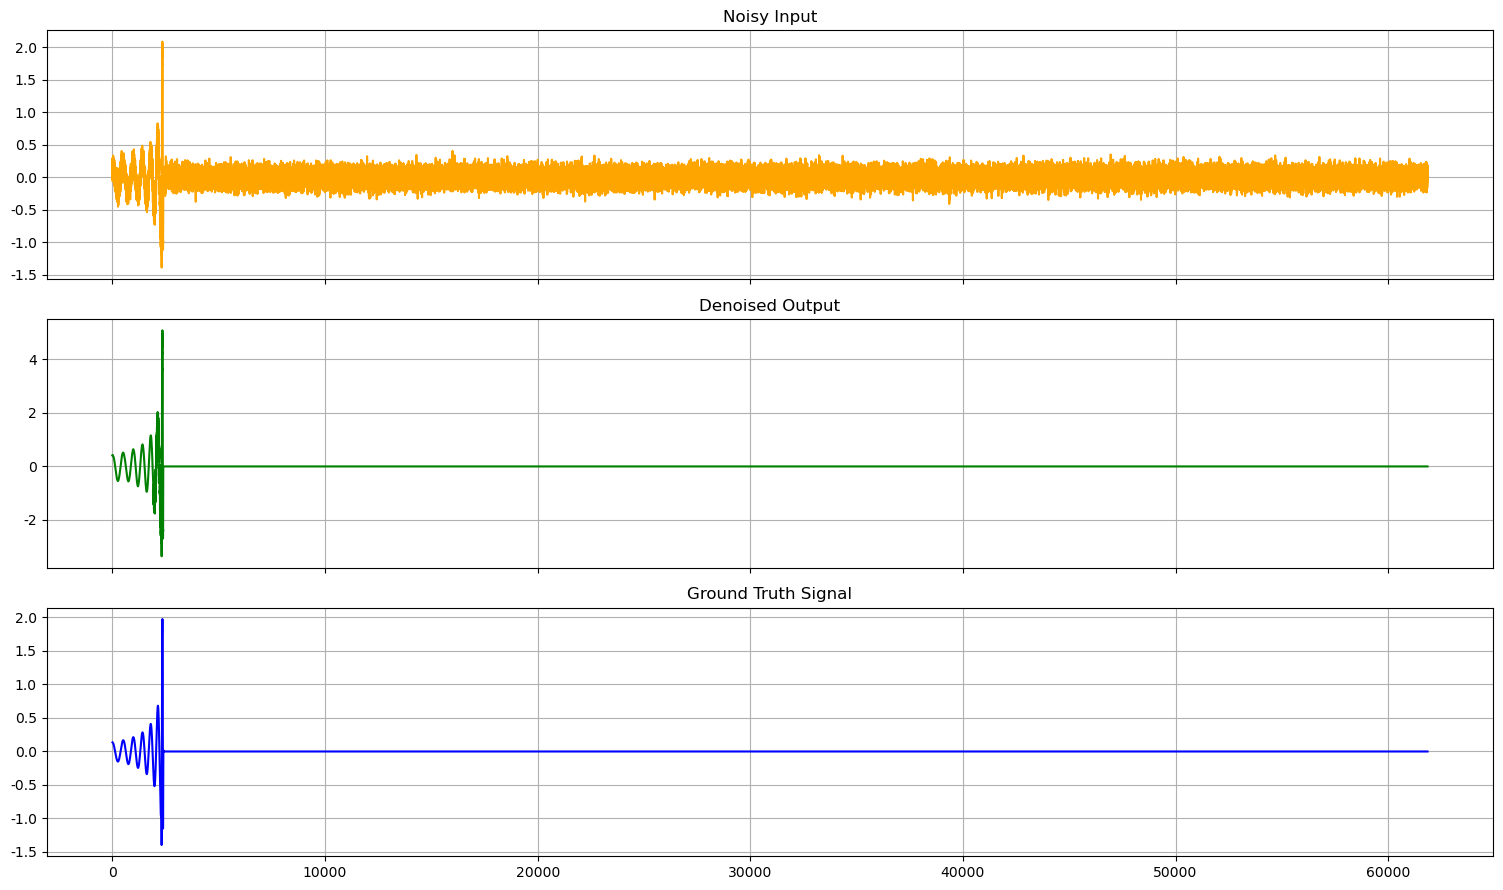

In [20]:
# test the trained best model
visualize_denoising_subplots(denoising_model, test_loader, device=device, sample_index=31)

In [21]:
# fine tuning with lower snr data
new_target_snr = ["50.00", "100.00"]  # Êñ∞ÁöÑSNRËÆæÁΩÆ
data_folder="/home/ud202180035/DNN_for_GW_Parameter_Space_Estimation/waveforms2"
# ÂàõÂª∫Êñ∞ÁöÑÊï∞ÊçÆÂä†ËΩΩÂô®
new_dataset = GWDataset(data_folder, snr_list=new_target_snr)
new_train_set, new_val_set, new_test_set = split_dataset(new_dataset)
        
new_train_loader = DataLoader(new_train_set, batch_size=32, shuffle=True, num_workers=24, pin_memory=True)
new_val_loader = DataLoader(new_val_set, batch_size=32, shuffle=False, num_workers=24, pin_memory=True)

ÊàêÂäüÂä†ËΩΩ 271359 ‰∏™Êñá‰ª∂


In [22]:
# ÂàõÂª∫Êñ∞ÁöÑ‰ºòÂåñÂô®ÔºàÂèØ‰ª•‰ΩøÁî®ËæÉÂ∞èÁöÑÂ≠¶‰π†ÁéáËøõË°åÂæÆË∞ÉÔºâ
optimizer = torch.optim.Adam(denoising_model.parameters(), lr=1e-6, weight_decay=1e-6)  # Êõ¥Â∞èÁöÑÂ≠¶‰π†Áéá

In [23]:
# ÁªßÁª≠ËÆ≠ÁªÉ
best_loss = train_model_with_checkpoints(
            model=denoising_model,
            train_loader=new_train_loader,
            val_loader=new_val_loader,
            optimizer=optimizer,
            device=device,
            num_epochs=60,  # ÂæÆË∞ÉËΩÆÊ¨°
            checkpoint_manager=checkpoint_manager,
            resume_from_checkpoint="model_checkpoints/checkpoint_epoch_40_20250710_164543.pt",
            save_every_n_epochs=10,
            training_config={
                'fine_tuning': True,
                'original_data': "waveforms2",
                'new_data': "waveforms2",
                'new_snr': new_target_snr,
                'learning_rate': optimizer.param_groups[0]['lr']
            }
        )

/home/ud202180035/miniconda3/envs/dnn/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


‚ùå Âä†ËΩΩÊ£ÄÊü•ÁÇπÂ§±Ë¥•: Ê£ÄÊü•ÁÇπÊñá‰ª∂‰∏çÂ≠òÂú®: model_checkpoints/checkpoint_epoch_40_20250710_164543.pt
üÜï ‰ªéÂ§¥ÂºÄÂßãËÆ≠ÁªÉ
üöÄ ÂºÄÂßãËÆ≠ÁªÉ:
   - Ê®°Âûã: WaveUNetWithTransformer
   - ÊÄªÂèÇÊï∞Èáè: 2,497,729
   - ÂèØËÆ≠ÁªÉÂèÇÊï∞: 2,497,729
   - ËÆæÂ§á: cuda
   - ËÆ≠ÁªÉËΩÆÊ¨°: 0 -> 60
   - Â≠¶‰π†Áéá: 1e-06
  1/60: Train Loss = 26.278693, Val Loss = 2.468107, Output Std = 0.2427, LR = 1.00e-06
üèÜ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: model_checkpoints/best_denoising_model.pt (È™åËØÅÊçüÂ§±: 2.468107)
  üèÜ Best model saved!
  2/60: Train Loss = 2.291680, Val Loss = 2.198200, Output Std = 0.2472, LR = 1.00e-06
üèÜ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: model_checkpoints/best_denoising_model.pt (È™åËØÅÊçüÂ§±: 2.198200)
  üèÜ Best model saved!
  3/60: Train Loss = 2.197308, Val Loss = 2.170144, Output Std = 0.2492, LR = 1.00e-06
üèÜ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: model_checkpoints/best_denoising_model.pt (È™åËØÅÊçüÂ§±: 2.170144)
  üèÜ Best model saved!
  4/60: Train Loss = 2.179067, Val Loss = 2.157876, Output S

In [24]:
# load the best model
checkpoint_manager.load_best_model(denoising_model,'best_denoising_model.pt', device)

üèÜ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤Âä†ËΩΩ: model_checkpoints/best_denoising_model.pt
   - È™åËØÅÊçüÂ§±: 2.059057
   - ‰øùÂ≠òÊó∂Èó¥: 2025-07-24T21:02:35.259774


In [29]:
# test the trained best model
new_test_loader = DataLoader(new_test_set, batch_size=32, shuffle=False, num_workers=24, pin_memory=True)

tensor([[1, 1, 1,  ..., 2, 2, 2]], device='cuda:0')
[0.10563019 0.10742797 0.1836593  ... 0.         0.         0.        ]


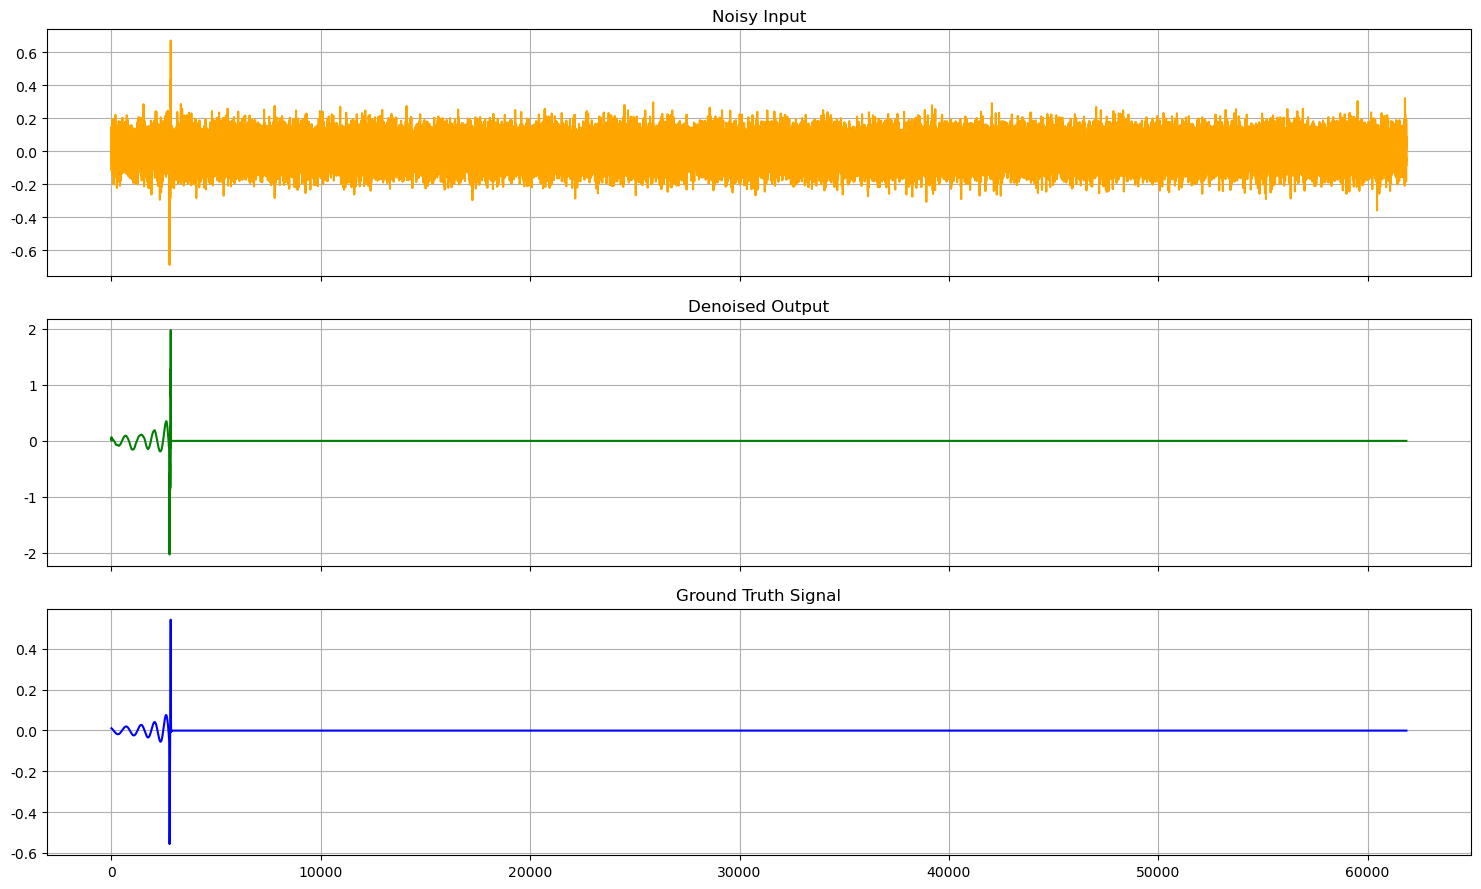

In [40]:
visualize_denoising_subplots(denoising_model, new_test_loader, device=device, sample_index=5)

In [38]:
list_available_checkpoints(checkpoint_manager)

üìã ÂèØÁî®ÁöÑÊ£ÄÊü•ÁÇπ:
--------------------------------------------------------------------------------
 1. final_checkpoint_epoch_60.pt
     ËΩÆÊ¨°: 60
     È™åËØÅÊçüÂ§±: 2.061387128776537
     ‰øùÂ≠òÊó∂Èó¥: 2025-07-24T23:23:49.476087

 2. checkpoint_epoch_60_20250724_232348.pt
     ËΩÆÊ¨°: 60
     È™åËØÅÊçüÂ§±: 2.061387128776537
     ‰øùÂ≠òÊó∂Èó¥: 2025-07-24T23:23:48.989894

 3. checkpoint_epoch_170_20250702_220525.pt
     ËΩÆÊ¨°: 170
     È™åËØÅÊçüÂ§±: 1.502203934597519
     ‰øùÂ≠òÊó∂Èó¥: 2025-07-02T22:05:25.975564

 4. checkpoint_epoch_180_20250703_010233.pt
     ËΩÆÊ¨°: 180
     È™åËØÅÊçüÂ§±: 1.502083161388928
     ‰øùÂ≠òÊó∂Èó¥: 2025-07-03T01:02:33.248890

 5. checkpoint_epoch_190_20250703_040415.pt
     ËΩÆÊ¨°: 190
     È™åËØÅÊçüÂ§±: 1.5020315228205807
     ‰øùÂ≠òÊó∂Èó¥: 2025-07-03T04:04:15.690666

 6. checkpoint_epoch_200_20250703_070351.pt
     ËΩÆÊ¨°: 200
     È™åËØÅÊçüÂ§±: 1.5021693772583637
     ‰øùÂ≠òÊó∂Èó¥: 2025-07-03T07:03:51.758451

 7. final_checkpoint_epoch_200.pt
  

In [41]:
test_model_and_save_labels_batched(model=denoising_model, test_loader=new_test_loader, device=device, output_dir="pt_chunks")

/tmp/ipykernel_42419/979834846.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mc = torch.tensor(batch["mc_true"], dtype=torch.float32).view(-1, 1)
/tmp/ipykernel_42419/979834846.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phis = torch.tensor(batch["phis_true"], dtype=torch.float32).view(-1, 1)
/tmp/ipykernel_42419/979834846.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  thetas = torch.tensor(batch["thetas_true"], dtype=torch.float32).view(-1, 1)


[Saved] pt_chunks/denoised_batch_0000.pt ‚Üê 32 samples
[Saved] pt_chunks/denoised_batch_0001.pt ‚Üê 32 samples
[Saved] pt_chunks/denoised_batch_0002.pt ‚Üê 32 samples
[Saved] pt_chunks/denoised_batch_0003.pt ‚Üê 32 samples
[Saved] pt_chunks/denoised_batch_0004.pt ‚Üê 32 samples
[Saved] pt_chunks/denoised_batch_0005.pt ‚Üê 32 samples
[Saved] pt_chunks/denoised_batch_0006.pt ‚Üê 32 samples
[Saved] pt_chunks/denoised_batch_0007.pt ‚Üê 32 samples
[Saved] pt_chunks/denoised_batch_0008.pt ‚Üê 32 samples
[Saved] pt_chunks/denoised_batch_0009.pt ‚Üê 32 samples
[Saved] pt_chunks/denoised_batch_0010.pt ‚Üê 32 samples
[Saved] pt_chunks/denoised_batch_0011.pt ‚Üê 32 samples
[Saved] pt_chunks/denoised_batch_0012.pt ‚Üê 32 samples
[Saved] pt_chunks/denoised_batch_0013.pt ‚Üê 32 samples
[Saved] pt_chunks/denoised_batch_0014.pt ‚Üê 32 samples
[Saved] pt_chunks/denoised_batch_0015.pt ‚Üê 32 samples
[Saved] pt_chunks/denoised_batch_0016.pt ‚Üê 32 samples
[Saved] pt_chunks/denoised_batch_0017.pt ‚Üê 32 